In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.metrics

water_data_m3: pd.DataFrame = pd.read_csv("water_data.csv")
spending_data_quantile_rp: pd.DataFrame = pd.read_csv("spending_data.csv")
population_data: pd.DataFrame = pd.read_csv("population_data.csv")
city_spending_data_rp: pd.DataFrame = pd.read_csv("city_spending_data.csv")
water_spending_rp: pd.DataFrame = pd.read_csv("water_spending.csv")
districts: pd.Series = water_data_m3["District"].to_list()
districts.pop()

display(water_data_m3)
display(population_data)
display(spending_data_quantile_rp)
display(city_spending_data_rp)
display(water_spending_rp)

,District,2017,2018,2019,2020,2021,2022,2023
0,Kedungkandang,6566405,6957957,6364264,7186039,7233227,7472993,7701113
1,Sukun,5864236,6093731,5701541,6088016,6155527,6248290,6546303
2,Klojen,5373575,5469639,4868369,4869511,5162387,5095361,5381262
3,Blimbing,6061895,6308611,6508462,6414178,7147949,6421637,7188327
4,Lowokwaru,7533319,7905237,6872733,7106526,7542021,7899145,8166814
5,Total,31399430,32735175,30315369,31664270,33241111,33137426,34983819


,District,2017,2018,2019,2020,2021,2022,2023
0,Kedungkandang,212459,212459,220055,222742,225337,210211,214157
1,Sukun,209053,209062,214623,216055,216918,202682,204970
2,Klojen,110073,110073,111053,111313,110796,100257,100712
3,Blimbing,198428,198428,202514,203211,203380,189534,190799
4,Lowokwaru,174152,174152,179040,180418,181445,168439,170149
5,Total,904165,904174,927195,933739,937876,871123,880787


,Quantile,2017,2018,2019,2020,2021,2022,2023
0,Q1,507792,601606,558053,546126,566065,698385,648472
1,Q2,790890,906102,878883,851121,905034,995285,950575
2,Q3,1174577,1328382,1318061,1264300,1297978,1349379,1313173
3,Q4,1717888,1870774,1930790,1986977,2035489,1993892,2012753
4,Q5,3914392,3333732,4031312,4178298,4585568,4907348,4851712
5,Average,1619392,1608906,1743569,1766014,1878933,1989831,1954957


,Spending Type,2017,2018,2019,2020,2021,2022,2023
0,Operational,1.473420e+12,1.570000e+12,1.670000e+12,1.690000e+12,1.890000e+12,1.870000e+12,2.190000e+12
1,Assets,3.404940e+11,3.510000e+11,2.390000e+11,3.630000e+11,2.950000e+11,3.110000e+11,4.060000e+11
2,Emergency/Miscellaneous,0.000000e+00,3.408054e+07,1.357371e+09,5.461481e+10,4.555465e+10,6.381986e+09,2.875454e+09
3,Total,1.813920e+12,1.930000e+12,1.910000e+12,2.100000e+12,2.230000e+12,2.190000e+12,2.600000e+12


,District,2017,2018,2019,2020,2021,2022,2023
0,Kedungkandang,34804717300,29254753600,27383762500,30458392400,30845996700,31836763600,41723833400
1,Sukun,31666701400,26482344800,25218673900,26266484900,27125148900,27184392900,36105529800
2,Klojen,35280270500,30587263100,27331348500,26561182200,29455553600,28809525600,36540902000
3,Blimbing,33930849000,28362786600,30878146300,29069956400,34144127000,29165067000,41826587300
4,Lowokwaru,43629441900,38149732000,33386573000,34759242700,36781012200,39114640400,49572070700
5,Total,179311980100,152836880100,144198504200,147115258600,158351838400,156110389500,205768923200


In [2]:
def reshape_to_long(frame: pd.DataFrame, var_name: str, value_name: str) -> pd.DataFrame:
	df = frame.copy(deep=True)
	df.set_index(var_name, inplace=True)
	if "Total" in df.index:
		df.drop("Total", inplace=True)
	if "Average" in df.index:
		df.drop("Average", inplace=True)
	df = df.T
	df.index = df.index.astype(int)
	df.index.name = "Year"
	return df.reset_index().melt(id_vars="Year", var_name=var_name, value_name=value_name)

water_data_m3_long = reshape_to_long(water_data_m3, "District", "Water Used (m3)")
population_data_long = reshape_to_long(population_data, "District", "Population")
city_spending_data_rp_long = reshape_to_long(city_spending_data_rp, "Spending Type", "City Spending (Rp)")
water_spending_rp_long = reshape_to_long(water_spending_rp, "District", "Water Spending (Rp)")
spending_data_quantile_rp_long = reshape_to_long(spending_data_quantile_rp, "Quantile", "Citizen Spending (Rp)")

display(water_data_m3_long)
display(city_spending_data_rp_long)
display(water_spending_rp_long)
display(population_data_long)
display(spending_data_quantile_rp_long)

,Year,District,Water Used (m3)
0,2017,Kedungkandang,6566405
1,2018,Kedungkandang,6957957
2,2019,Kedungkandang,6364264
3,2020,Kedungkandang,7186039
4,2021,Kedungkandang,7233227
5,2022,Kedungkandang,7472993
6,2023,Kedungkandang,7701113
7,2017,Sukun,5864236
8,2018,Sukun,6093731
9,2019,Sukun,5701541


,Year,Spending Type,City Spending (Rp)
0,2017,Operational,1.473420e+12
1,2018,Operational,1.570000e+12
2,2019,Operational,1.670000e+12
3,2020,Operational,1.690000e+12
4,2021,Operational,1.890000e+12
5,2022,Operational,1.870000e+12
6,2023,Operational,2.190000e+12
7,2017,Assets,3.404940e+11
8,2018,Assets,3.510000e+11
9,2019,Assets,2.390000e+11


,Year,District,Water Spending (Rp)
0,2017,Kedungkandang,34804717300
1,2018,Kedungkandang,29254753600
2,2019,Kedungkandang,27383762500
3,2020,Kedungkandang,30458392400
4,2021,Kedungkandang,30845996700
5,2022,Kedungkandang,31836763600
6,2023,Kedungkandang,41723833400
7,2017,Sukun,31666701400
8,2018,Sukun,26482344800
9,2019,Sukun,25218673900


,Year,District,Population
0,2017,Kedungkandang,212459
1,2018,Kedungkandang,212459
2,2019,Kedungkandang,220055
3,2020,Kedungkandang,222742
4,2021,Kedungkandang,225337
5,2022,Kedungkandang,210211
6,2023,Kedungkandang,214157
7,2017,Sukun,209053
8,2018,Sukun,209062
9,2019,Sukun,214623


,Year,Quantile,Citizen Spending (Rp)
0,2017,Q1,507792
1,2018,Q1,601606
2,2019,Q1,558053
3,2020,Q1,546126
4,2021,Q1,566065
5,2022,Q1,698385
6,2023,Q1,648472
7,2017,Q2,790890
8,2018,Q2,906102
9,2019,Q2,878883


In [3]:
city_spending_rp_long_pivot = city_spending_data_rp_long.pivot(index="Year", columns="Spending Type", values="City Spending (Rp)").reset_index()
city_spending_rp_long_pivot.columns = ["Year", "Assets (Rp)", "Emergency/Miscellaneous (Rp)", "Operational (Rp)"]
spending_data_quantile_rp_long_pivot = spending_data_quantile_rp_long.pivot(index="Year", columns="Quantile", values="Citizen Spending (Rp)").reset_index()
spending_data_quantile_rp_long_pivot.columns = ["Year", "Q1 (Rp)", "Q2 (Rp)", "Q3 (Rp)", "Q4 (Rp)", "Q5 (Rp)"]

total_population_yearly = population_data_long.groupby("Year")["Population"].sum().reset_index().rename(columns={"Population":"Total Population"})

df = pd.merge(water_spending_rp_long, population_data_long, on=["Year", "District"])
df = pd.merge(df, water_data_m3_long, on=["Year", "District"])
df = pd.merge(df, city_spending_rp_long_pivot, on="Year", how="left")
df = pd.merge(df, spending_data_quantile_rp_long_pivot, on="Year", how="left")
df = pd.merge(df, total_population_yearly, on="Year", how="left")
df["Water Price / Capita (Rp/m3)"] = (df["Water Spending (Rp)"] / df["Water Used (m3)"])
df["Water Usage / Capita (m3/person)"] = (df["Water Used (m3)"] / df["Population"])
df["Water Spending / Capita (Rp/person)"] = (df["Water Spending (Rp)"] / df["Population"])
df.sort_values(by=["District", "Year"], inplace=True)

from pandas.core.groupby import DataFrameGroupBy

dg: DataFrameGroupBy = df.groupby("District")
parameters: list[str] = ["Water Spending (Rp)", "Water Used (m3)", "Assets (Rp)", "Emergency/Miscellaneous (Rp)", "Operational (Rp)", "Population", "Water Price / Capita (Rp/m3)", "Water Usage / Capita (m3/person)", "Water Spending / Capita (Rp/person)", "Q1 (Rp)", "Q2 (Rp)", "Q3 (Rp)", "Q4 (Rp)", "Q5 (Rp)"]
for parameter in parameters:
	df["Previous " + parameter] = dg[parameter].shift(1)

targets = parameters.copy()
parameters = parameters + ["Previous " + parameter for parameter in parameters]

# Convert invalid values to NaN to detect errors
num_cols: list[str] = [col for col in df.columns if col not in ["Year", "District"]]
for col in num_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df_model: pd.DataFrame = df.copy().dropna()

del df
del parameter
del col
del dg
del city_spending_rp_long_pivot
del spending_data_quantile_rp_long_pivot
del total_population_yearly

with pd.option_context("display.max_rows", None, "display.max_columns", None):
	display(df_model)

df_model.to_clipboard(sep=",")
df_model.info()

,Year,District,Water Spending (Rp),Population,Water Used (m3),Assets (Rp),Emergency/Miscellaneous (Rp),Operational (Rp),Q1 (Rp),Q2 (Rp),Q3 (Rp),Q4 (Rp),Q5 (Rp),Total Population,Water Price / Capita (Rp/m3),Water Usage / Capita (m3/person),Water Spending / Capita (Rp/person),Previous Water Spending (Rp),Previous Water Used (m3),Previous Assets (Rp),Previous Emergency/Miscellaneous (Rp),Previous Operational (Rp),Previous Population,Previous Water Price / Capita (Rp/m3),Previous Water Usage / Capita (m3/person),Previous Water Spending / Capita (Rp/person),Previous Q1 (Rp),Previous Q2 (Rp),Previous Q3 (Rp),Previous Q4 (Rp),Previous Q5 (Rp)
22,2018,Blimbing,28362786600,198428,6308611,3.510000e+11,3.408054e+07,1.570000e+12,601606,906102,1328382,1870774,3333732,904174,4495.884530,31.792948,142937.421130,3.393085e+10,6061895.0,3.404940e+11,0.000000e+00,1.473420e+12,198428.0,5597.399658,30.549595,170998.291572,507792.0,790890.0,1174577.0,1717888.0,3914392.0
23,2019,Blimbing,30878146300,202514,6508462,2.390000e+11,1.357371e+09,1.670000e+12,558053,878883,1318061,1930790,4031312,927285,4744.307687,32.138331,152474.131665,2.836279e+10,6308611.0,3.510000e+11,3.408054e+07,1.570000e+12,198428.0,4495.884530,31.792948,142937.421130,601606.0,906102.0,1328382.0,1870774.0,3333732.0
24,2020,Blimbing,29069956400,203211,6414178,3.630000e+11,5.461481e+10,1.690000e+12,546126,851121,1264300,1986977,4178298,933739,4532.140580,31.564128,143053.065041,3.087815e+10,6508462.0,2.390000e+11,1.357371e+09,1.670000e+12,202514.0,4744.307687,32.138331,152474.131665,558053.0,878883.0,1318061.0,1930790.0,4031312.0
25,2021,Blimbing,34144127000,203380,7147949,2.950000e+11,4.555465e+10,1.890000e+12,566065,905034,1297978,2035489,4585568,937876,4776.772610,35.145781,167883.405448,2.906996e+10,6414178.0,3.630000e+11,5.461481e+10,1.690000e+12,203211.0,4532.140580,31.564128,143053.065041,546126.0,851121.0,1264300.0,1986977.0,4178298.0
26,2022,Blimbing,29165067000,189534,6421637,3.110000e+11,6.381986e+09,1.870000e+12,698385,995285,1349379,1993892,4907348,871123,4541.687268,33.881188,153877.758080,3.414413e+10,7147949.0,2.950000e+11,4.555465e+10,1.890000e+12,203380.0,4776.772610,35.145781,167883.405448,566065.0,905034.0,1297978.0,2035489.0,4585568.0
27,2023,Blimbing,41826587300,190799,7188327,4.060000e+11,2.875454e+09,2.190000e+12,648472,950575,1313173,2012753,4851712,880787,5818.681774,37.674867,219218.063512,2.916507e+10,6421637.0,3.110000e+11,6.381986e+09,1.870000e+12,189534.0,4541.687268,33.881188,153877.758080,698385.0,995285.0,1349379.0,1993892.0,4907348.0
1,2018,Kedungkandang,29254753600,212459,6957957,3.510000e+11,3.408054e+07,1.570000e+12,601606,906102,1328382,1870774,3333732,904174,4204.503362,32.749646,137695.995933,3.480472e+10,6566405.0,3.404940e+11,0.000000e+00,1.473420e+12,212459.0,5300.421966,30.906693,163818.512278,507792.0,790890.0,1174577.0,1717888.0,3914392.0
2,2019,Kedungkandang,27383762500,220055,6364264,2.390000e+11,1.357371e+09,1.670000e+12,558053,878883,1318061,1930790,4031312,927285,4302.738306,28.921242,124440.537593,2.925475e+10,6957957.0,3.510000e+11,3.408054e+07,1.570000e+12,212459.0,4204.503362,32.749646,137695.995933,601606.0,906102.0,1328382.0,1870774.0,3333732.0
3,2020,Kedungkandang,30458392400,222742,7186039,3.630000e+11,5.461481e+10,1.690000e+12,546126,851121,1264300,1986977,4178298,933739,4238.550946,32.261715,136742.924101,2.738376e+10,6364264.0,2.390000e+11,1.357371e+09,1.670000e+12,220055.0,4302.738306,28.921242,124440.537593,558053.0,878883.0,1318061.0,1930790.0,4031312.0
4,2021,Kedungkandang,30845996700,225337,7233227,2.950000e+11,4.555465e+10,1.890000e+12,566065,905034,1297978,2035489,4585568,937876,4264.486197,32.099597,136888.290427,3.045839e+10,7186039.0,3.630000e+11,5.461481e+10,1.690000e+12,222742.0,4238.550946,32.261715,136742.924101,546126.0,851121.0,1264300.0,1986977.0,4178298.0


<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 22 to 13
Data columns (total 31 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Year                                          30 non-null     int64  
 1   District                                      30 non-null     object 
 2   Water Spending (Rp)                           30 non-null     int64  
 3   Population                                    30 non-null     int64  
 4   Water Used (m3)                               30 non-null     int64  
 5   Assets (Rp)                                   30 non-null     float64
 6   Emergency/Miscellaneous (Rp)                  30 non-null     float64
 7   Operational (Rp)                              30 non-null     float64
 8   Q1 (Rp)                                       30 non-null     int64  
 9   Q2 (Rp)                                       30 non-null     int64  
 

In [4]:
spear_corr = df_model[df_model.columns.difference(["Year", "District", "Water Used (m3)"])].corrwith(df_model["Water Used (m3)"], method="spearman")
display(pd.DataFrame(spear_corr, columns=["Correlation Value"]))
kend_corr = df_model[df_model.columns.difference(["Year", "District", "Water Used (m3)"])].corrwith(df_model["Water Used (m3)"], method="kendall")
display(pd.DataFrame(kend_corr, columns=["Correlation Value"]))
pear_corr = df_model[df_model.columns.difference(["Year", "District", "Water Used (m3)"])].corrwith(df_model["Water Used (m3)"], method="pearson")
display(pd.DataFrame(pear_corr, columns=["Correlation Value"]))

,Correlation Value
Assets (Rp),0.192802
Emergency/Miscellaneous (Rp),0.028187
Operational (Rp),0.271727
Population,0.264961
Previous Assets (Rp),-0.014657
Previous Emergency/Miscellaneous (Rp),0.188292
Previous Operational (Rp),0.219862
Previous Population,0.296239
Previous Q1 (Rp),0.068777
Previous Q2 (Rp),0.068777


,Correlation Value
Assets (Rp),0.146080
Emergency/Miscellaneous (Rp),0.002476
Operational (Rp),0.215407
Population,0.140230
Previous Assets (Rp),0.002476
Previous Emergency/Miscellaneous (Rp),0.146080
Previous Operational (Rp),0.185695
Previous Population,0.163974
Previous Q1 (Rp),0.051995
Previous Q2 (Rp),0.051995


,Correlation Value
Assets (Rp),0.223468
Emergency/Miscellaneous (Rp),-0.037733
Operational (Rp),0.248332
Population,0.572576
Previous Assets (Rp),0.001781
Previous Emergency/Miscellaneous (Rp),0.102302
Previous Operational (Rp),0.193554
Previous Population,0.584257
Previous Q1 (Rp),0.129832
Previous Q2 (Rp),0.114333


In [5]:
districts_map = {}
for i, d in enumerate(districts):
	districts_map[i] = d
	districts_map[d] = i

scoring: dict[str, str] = {
    "neg_mse": "neg_mean_squared_error", # Lower is better, negative for maximization
    "neg_rmse": "neg_root_mean_squared_error",
	"neg_mae": "neg_mean_absolute_error",
	"neg_mape": "neg_mean_absolute_percentage_error"
}

display(df_model)

,Year,District,Water Spending (Rp),Population,Water Used (m3),Assets (Rp),Emergency/Miscellaneous (Rp),Operational (Rp),Q1 (Rp),Q2 (Rp),...,Previous Operational (Rp),Previous Population,Previous Water Price / Capita (Rp/m3),Previous Water Usage / Capita (m3/person),Previous Water Spending / Capita (Rp/person),Previous Q1 (Rp),Previous Q2 (Rp),Previous Q3 (Rp),Previous Q4 (Rp),Previous Q5 (Rp)
22,2018,Blimbing,28362786600,198428,6308611,3.510000e+11,3.408054e+07,1.570000e+12,601606,906102,...,1.473420e+12,198428.0,5597.399658,30.549595,170998.291572,507792.0,790890.0,1174577.0,1717888.0,3914392.0
23,2019,Blimbing,30878146300,202514,6508462,2.390000e+11,1.357371e+09,1.670000e+12,558053,878883,...,1.570000e+12,198428.0,4495.884530,31.792948,142937.421130,601606.0,906102.0,1328382.0,1870774.0,3333732.0
24,2020,Blimbing,29069956400,203211,6414178,3.630000e+11,5.461481e+10,1.690000e+12,546126,851121,...,1.670000e+12,202514.0,4744.307687,32.138331,152474.131665,558053.0,878883.0,1318061.0,1930790.0,4031312.0
25,2021,Blimbing,34144127000,203380,7147949,2.950000e+11,4.555465e+10,1.890000e+12,566065,905034,...,1.690000e+12,203211.0,4532.140580,31.564128,143053.065041,546126.0,851121.0,1264300.0,1986977.0,4178298.0
26,2022,Blimbing,29165067000,189534,6421637,3.110000e+11,6.381986e+09,1.870000e+12,698385,995285,...,1.890000e+12,203380.0,4776.772610,35.145781,167883.405448,566065.0,905034.0,1297978.0,2035489.0,4585568.0
27,2023,Blimbing,41826587300,190799,7188327,4.060000e+11,2.875454e+09,2.190000e+12,648472,950575,...,1.870000e+12,189534.0,4541.687268,33.881188,153877.758080,698385.0,995285.0,1349379.0,1993892.0,4907348.0
1,2018,Kedungkandang,29254753600,212459,6957957,3.510000e+11,3.408054e+07,1.570000e+12,601606,906102,...,1.473420e+12,212459.0,5300.421966,30.906693,163818.512278,507792.0,790890.0,1174577.0,1717888.0,3914392.0
2,2019,Kedungkandang,27383762500,220055,6364264,2.390000e+11,1.357371e+09,1.670000e+12,558053,878883,...,1.570000e+12,212459.0,4204.503362,32.749646,137695.995933,601606.0,906102.0,1328382.0,1870774.0,3333732.0
3,2020,Kedungkandang,30458392400,222742,7186039,3.630000e+11,5.461481e+10,1.690000e+12,546126,851121,...,1.670000e+12,220055.0,4302.738306,28.921242,124440.537593,558053.0,878883.0,1318061.0,1930790.0,4031312.0
4,2021,Kedungkandang,30845996700,225337,7233227,2.950000e+11,4.555465e+10,1.890000e+12,566065,905034,...,1.690000e+12,222742.0,4238.550946,32.261715,136742.924101,546126.0,851121.0,1264300.0,1986977.0,4178298.0


In [ ]:
from sklearn.svm import SVR
import sklearn.feature_selection
from sklearn.model_selection import GridSearchCV, LeaveOneOut, RepeatedKFold
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing

# Define hyperparameters to tune (example)
param_grid: dict[str, list[float] | list[str] | list[str | float]] = {
	'C': [0.01, 0.02, 0.05, 0.1, 1],          # Regularization parameter (common to all kernels)
    'epsilon': [1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 0.01, 0.05, 0.1, 0.5],     # Epsilon-SVR parameter (common to all kernels)
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], # The kernel type
    'degree': [2, 3, 4, 5, 6],            # Degree for 'poly' kernel (ignored for others)
    'gamma': ['scale', 'auto', 0.01, 0.05, 0.1, 0.5, 1], # Kernel coefficient for 'rbf', 'poly', 'sigmoid' (ignored for 'linear')
    'coef0': [0.1, 0.5, 0.9, 0.95, 1]
}

scoring: dict[str, str] = {
    "neg_mse": "neg_mean_squared_error", # Lower is better, negative for maximization
    "neg_rmse": "neg_root_mean_squared_error",
	"neg_mae": "neg_mean_absolute_error",
	"neg_mape": "neg_mean_absolute_percentage_error"
}

# results: dict[str, dict[str, tuple[SVR, dict, float]]] = { district:{ scoring_name:None for scoring_name in scoring.values() } for district in districts }
results_svr: dict[str, dict | pd.DataFrame | float | StandardScaler | SVR] = {scoring_name:None for scoring_name in scoring.keys()}
# for district in districts:
# 	print(f"Measuring best SVR model for district {district}")
for scoring_name, scoring_method in scoring.items():
	svr: SVR = SVR()
	gscv: GridSearchCV = GridSearchCV(svr, param_grid=param_grid, cv=RepeatedKFold(n_splits=5, random_state=69420), scoring=scoring_method, refit=scoring_name, n_jobs=-1)
	# district_df = df_model[df_model["District"] == district].copy()
	X: pd.DataFrame = df_model[["District", "Water Spending (Rp)","Population","Water Used (m3)","Assets (Rp)","Operational (Rp)","Total Population","Water Price / Capita (Rp/m3)", "Water Usage / Capita (m3/person)", "Water Spending / Capita (Rp/person)", "Previous Water Used (m3)", "Previous Water Price / Capita (Rp/m3)", "Previous Water Usage / Capita (m3/person)", "Previous Water Spending / Capita (Rp/person)"]].copy()
	X["District"] = X["District"].map(districts_map)
	Y: pd.DataFrame = pd.DataFrame(df_model["Water Used (m3)"])
	feature_scaler: StandardScaler = StandardScaler()
	target_scaler: StandardScaler = StandardScaler()
	X_norm: np.ndarray = feature_scaler.fit_transform(X)
	Y_norm: np.ndarray = target_scaler.fit_transform(Y.to_numpy().reshape(-1, 1)).ravel()
	gscv.fit(X_norm, Y_norm)
	best_svr = gscv.best_estimator_
	print(f"Best SVR parameters (refit={scoring_name}): {gscv.best_params_}")
	print(f"Best score {gscv.best_score_}")
	cv_results_df = pd.DataFrame(gscv.cv_results_)
	results_svr[scoring_name] = {
	# results[district][scoring_name] = {
		"model":best_svr,
		"params":gscv.best_params_,
		"score":gscv.best_score_,
		"feature_scaler": feature_scaler,
		"target_scaler": target_scaler,
		"result_table": cv_results_df
	}
	# Access all scores from cv_results_
	display(cv_results_df[["param_C","param_coef0","param_degree","param_epsilon","param_gamma","param_kernel","split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score","split5_test_score", "mean_test_score", "std_test_score", "rank_test_score"]])
	

Best SVR parameters (refit=neg_mse): {'C': 1, 'coef0': 0.1, 'degree': 2, 'epsilon': 1e-05, 'gamma': 'scale', 'kernel': 'linear'}
Best score -0.0002630681382155026


,param_C,param_coef0,param_degree,param_epsilon,param_gamma,param_kernel,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.1,2,1.000000e-08,scale,linear,-0.223383,-0.246454,-0.316658,-0.205577,-0.757173,-0.181243,-0.337342,0.171570,10659
1,0.01,0.1,2,1.000000e-08,scale,poly,-0.613939,-0.688038,-1.480854,-0.788391,-2.161449,-0.829620,-1.018366,0.457519,23283
2,0.01,0.1,2,1.000000e-08,scale,rbf,-0.611002,-0.695664,-1.539309,-0.832783,-2.193828,-0.854681,-1.052855,0.471499,26476
3,0.01,0.1,2,1.000000e-08,scale,sigmoid,-0.601637,-0.693592,-1.510290,-0.811762,-2.112272,-0.827225,-1.023055,0.452717,23492
4,0.01,0.1,2,1.000000e-08,auto,linear,-0.223383,-0.246454,-0.316658,-0.205577,-0.757173,-0.181243,-0.337342,0.171570,10659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,1.00,1.0,6,5.000000e-01,0.5,sigmoid,-3.758469,-6.032551,-6.638267,-2.230791,-4.379908,-1.608525,-3.765219,2.245930,30661
31496,1.00,1.0,6,5.000000e-01,1,linear,-0.131583,-0.141136,-0.096250,-0.077934,-0.309047,-0.099821,-0.160195,0.071421,6515
31497,1.00,1.0,6,5.000000e-01,1,poly,-0.349932,-0.315102,-1.458479,-0.655216,-0.921034,-0.338000,-1.027982,1.040712,23967
31498,1.00,1.0,6,5.000000e-01,1,rbf,-0.647251,-0.674755,-1.081482,-0.893945,-2.159252,-0.786908,-1.056639,0.486131,27290


Best SVR parameters (refit=neg_rmse): {'C': 1, 'coef0': 0.1, 'degree': 2, 'epsilon': 1e-05, 'gamma': 'scale', 'kernel': 'linear'}
Best score -0.011535240185169665


,param_C,param_coef0,param_degree,param_epsilon,param_gamma,param_kernel,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.1,2,1.000000e-08,scale,linear,-0.472634,-0.496442,-0.562724,-0.453406,-0.870157,-0.425726,-0.562186,0.145908,11005
1,0.01,0.1,2,1.000000e-08,scale,poly,-0.783543,-0.829480,-1.216904,-0.887914,-1.470187,-0.910835,-0.983274,0.227022,23523
2,0.01,0.1,2,1.000000e-08,scale,rbf,-0.781666,-0.834065,-1.240689,-0.912570,-1.481158,-0.924489,-0.999698,0.231212,26907
3,0.01,0.1,2,1.000000e-08,scale,sigmoid,-0.775652,-0.832822,-1.228939,-0.900978,-1.453366,-0.909519,-0.986017,0.225444,23895
4,0.01,0.1,2,1.000000e-08,auto,linear,-0.472634,-0.496442,-0.562724,-0.453406,-0.870157,-0.425726,-0.562186,0.145908,11005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,1.00,1.0,6,5.000000e-01,0.5,sigmoid,-1.938677,-2.456125,-2.576483,-1.493583,-2.092823,-1.268276,-1.854508,0.570981,30876
31496,1.00,1.0,6,5.000000e-01,1,linear,-0.362744,-0.375681,-0.310242,-0.279167,-0.555920,-0.315945,-0.391059,0.085254,6632
31497,1.00,1.0,6,5.000000e-01,1,poly,-0.591550,-0.561339,-1.207675,-0.809454,-0.959705,-0.581378,-0.923103,0.419361,18921
31498,1.00,1.0,6,5.000000e-01,1,rbf,-0.804519,-0.821435,-1.039943,-0.945487,-1.469439,-0.887078,-1.000028,0.237873,27146


Best SVR parameters (refit=neg_mae): {'C': 1, 'coef0': 0.1, 'degree': 2, 'epsilon': 1e-05, 'gamma': 'scale', 'kernel': 'linear'}
Best score -0.007635144804744859


,param_C,param_coef0,param_degree,param_epsilon,param_gamma,param_kernel,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.1,2,1.000000e-08,scale,linear,-0.409985,-0.366569,-0.424564,-0.399204,-0.864044,-0.369202,-0.483363,0.147741,11123
1,0.01,0.1,2,1.000000e-08,scale,poly,-0.617012,-0.628365,-1.086027,-0.799291,-1.433485,-0.750095,-0.848310,0.242360,24035
2,0.01,0.1,2,1.000000e-08,scale,rbf,-0.614608,-0.632095,-1.098977,-0.818915,-1.441532,-0.763424,-0.860860,0.247436,27276
3,0.01,0.1,2,1.000000e-08,scale,sigmoid,-0.612417,-0.629980,-1.086194,-0.809670,-1.415655,-0.753072,-0.849605,0.242063,24370
4,0.01,0.1,2,1.000000e-08,auto,linear,-0.409985,-0.366569,-0.424564,-0.399204,-0.864044,-0.369202,-0.483363,0.147741,11123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,1.00,1.0,6,5.000000e-01,0.5,sigmoid,-1.287624,-1.953485,-1.777501,-1.339099,-1.498616,-0.791293,-1.514680,0.466189,30996
31496,1.00,1.0,6,5.000000e-01,1,linear,-0.334542,-0.292196,-0.268749,-0.236411,-0.543468,-0.286701,-0.348586,0.082437,7255
31497,1.00,1.0,6,5.000000e-01,1,poly,-0.544466,-0.511667,-0.935969,-0.667579,-0.906029,-0.528924,-0.760196,0.274315,17477
31498,1.00,1.0,6,5.000000e-01,1,rbf,-0.615970,-0.621807,-0.862796,-0.819557,-1.419679,-0.711383,-0.850717,0.251920,24806


Best SVR parameters (refit=neg_mape): {'C': 1, 'coef0': 0.1, 'degree': 2, 'epsilon': 1e-07, 'gamma': 'scale', 'kernel': 'linear'}
Best score -0.02249437731664194


,param_C,param_coef0,param_degree,param_epsilon,param_gamma,param_kernel,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,0.01,0.1,2,1.000000e-08,scale,linear,-0.838299,-2.103542,-0.647056,-0.519602,-0.661081,-1.459273,-1.227246,1.246538,9202
1,0.01,0.1,2,1.000000e-08,scale,poly,-0.874132,-2.889826,-4.091975,-0.992944,-1.050753,-3.017210,-1.499460,0.787644,17215
2,0.01,0.1,2,1.000000e-08,scale,rbf,-0.872355,-3.123932,-4.069735,-1.009519,-1.050760,-3.251773,-1.546208,0.843926,20748
3,0.01,0.1,2,1.000000e-08,scale,sigmoid,-0.876270,-3.108838,-3.993839,-1.000677,-1.032842,-3.247872,-1.525485,0.826253,18854
4,0.01,0.1,2,1.000000e-08,auto,linear,-0.838299,-2.103542,-0.647056,-0.519602,-0.661081,-1.459273,-1.227246,1.246538,9202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31495,1.00,1.0,6,5.000000e-01,0.5,sigmoid,-1.940909,-8.060651,-3.036068,-2.399971,-1.111231,-6.447101,-7.723502,11.434807,31086
31496,1.00,1.0,6,5.000000e-01,1,linear,-1.003238,-5.069251,-0.734357,-0.305766,-0.409826,-2.632034,-1.309085,1.430443,11098
31497,1.00,1.0,6,5.000000e-01,1,poly,-1.484682,-7.093812,-3.610464,-0.775572,-0.644713,-6.514823,-2.623122,2.103140,30059
31498,1.00,1.0,6,5.000000e-01,1,rbf,-0.807808,-2.658532,-2.253773,-0.959058,-1.020838,-1.282339,-1.216213,0.451922,7451


In [7]:
import joblib
joblib.dump(results_svr, "results_svr.joblib")

['results_svr.joblib']

In [ ]:
import joblib
results_svr = joblib.load("results_svr.joblib")

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import sklearn.feature_selection
from sklearn.model_selection import GridSearchCV, LeaveOneOut, RepeatedKFold
from sklearn.preprocessing import StandardScaler
import sklearn.preprocessing

results_mlp: dict[str, dict | pd.DataFrame | float | StandardScaler | SVR] = { scoring_name:None for scoring_name in scoring.keys() }

mlp_param_list: dict[str, list[tuple] | list[str] | list[float] | int] = {
	"hidden_layer_sizes": [(10,20,25), (20,40,50)], 
	"activation": ["identity", "logistic", "tanh", "relu"], 
	"solver": ["sgd", "adam"], 
	"alpha": [0.001,0.01,0.1],
	"learning_rate": ["constant",  "invscaling", "adaptive"],
	"beta_1": [0.8, 0.9],
	"beta_2": [0.99, 0.999],
	"epsilon": [1e-8, 1e-7],
	"max_iter": [1000],
	"learning_rate_init": [0.01, 0.1]
}

for scoring_name, scoring_method in scoring.items():
	regressor = MLPRegressor()
	gscv: GridSearchCV = GridSearchCV(regressor, param_grid=mlp_param_list, cv=RepeatedKFold(n_splits=5, random_state=69420), scoring=scoring_method, refit=scoring_name, n_jobs=-1)
	X: pd.DataFrame = df_model[["District", "Water Spending (Rp)","Population","Water Used (m3)","Assets (Rp)","Operational (Rp)","Total Population","Water Price / Capita (Rp/m3)", "Water Usage / Capita (m3/person)", "Water Spending / Capita (Rp/person)", "Previous Water Used (m3)", "Previous Water Price / Capita (Rp/m3)", "Previous Water Usage / Capita (m3/person)", "Previous Water Spending / Capita (Rp/person)"]].copy()
	X["District"] = X["District"].map(districts_map)
	Y: pd.DataFrame = pd.DataFrame(df_model["Water Used (m3)"])
	feature_scaler: StandardScaler = StandardScaler()
	target_scaler: StandardScaler = StandardScaler()
	X_norm: np.ndarray = feature_scaler.fit_transform(X)
	if np.count_nonzero(np.isnan(X_norm)) > 0:
		print(np.where(pd.DataFrame(X_norm).isna()))
		raise ValueError("X_norm contains NaN")
	if np.count_nonzero(np.isnan(Y_norm)) > 0:
		print(np.where(pd.DataFrame(Y_norm).isna()))
		raise ValueError("Y_norm contains NaN")
	Y_norm: np.ndarray = target_scaler.fit_transform(Y.to_numpy().reshape(-1, 1)).ravel()
	gscv.fit(X_norm, Y_norm)
	best_mlp = gscv.best_estimator_
	print(f"Best MLP parameters (refit={scoring_name}): {gscv.best_params_}")
	print(f"Best score {gscv.best_score_}")
	cv_results_df = pd.DataFrame(gscv.cv_results_)
	results_mlp[scoring_name] = {
		"model":best_mlp,
		"params":gscv.best_params_,
		"score":gscv.best_score_,
		"feature_scaler": feature_scaler,
		"target_scaler": target_scaler,
		"result_table": cv_results_df
	}
	display(cv_results_df[["params","split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score","split5_test_score", "mean_test_score", "std_test_score", "rank_test_score"]])

C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5765 fits failed out of a total of 115200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5765 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz

Best MLP parameters (refit=neg_mse): {'activation': 'identity', 'alpha': 0.1, 'beta_1': 0.8, 'beta_2': 0.99, 'epsilon': 1e-07, 'hidden_layer_sizes': (10, 20, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
Best score -0.0018988431512947566


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.031082,-0.003003,-0.005190,-0.023661,-0.058482,-0.024007,-0.017096,0.016032,320
1,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.017374,-0.001316,-0.012178,-0.003341,-0.008819,-0.001752,-0.007748,0.006610,181
2,"{'activation': 'identity', 'alpha': 0.001, 'be...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2160
3,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.009017,-0.002122,-0.007243,-0.009827,-0.007376,-0.002114,-0.113266,0.385928,929
4,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.313930,-0.073057,-0.898730,-0.169243,-0.230938,-0.508339,-0.658203,0.742894,1686
...,...,...,...,...,...,...,...,...,...,...
2299,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.528796,-0.290245,-0.459911,-0.586696,-1.105751,-0.707662,-0.639403,0.521491,1677
2300,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.111404,-0.132892,-0.098139,-0.049080,-0.108532,-0.121805,-0.098619,0.077525,845
2301,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.054125,-0.093658,-0.018124,-0.026270,-0.050656,-0.075625,-0.033369,0.027546,458
2302,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.012424,-0.065798,-0.084431,-0.010688,-0.046303,-0.061747,-0.032884,0.036604,455


C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5792 fits failed out of a total of 115200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5792 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz

Best MLP parameters (refit=neg_rmse): {'activation': 'identity', 'alpha': 0.1, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'hidden_layer_sizes': (10, 20, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
Best score -0.041098524437183065


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.153458,-0.070837,-0.134476,-0.070614,-0.131722,-0.066022,-0.108664,0.046221,294
1,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.040580,-0.030976,-0.057391,-0.066907,-0.114738,-0.061004,-0.071143,0.032747,138
2,"{'activation': 'identity', 'alpha': 0.001, 'be...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2161
3,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.235937,-0.092992,-0.075589,-0.031200,-0.070383,-0.052460,-0.194725,0.281515,541
4,"{'activation': 'identity', 'alpha': 0.001, 'be...",-1.575093,-0.466414,-0.306804,-0.264390,-0.693985,-0.576134,-0.706881,0.420036,1722
...,...,...,...,...,...,...,...,...,...,...
2299,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.344376,-0.452919,-0.152568,-0.223440,-1.067260,-0.240466,-0.638500,0.354949,1628
2300,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.233106,-0.278669,-0.346180,-0.373426,-0.442310,-0.386486,-0.296147,0.089112,893
2301,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.119465,-0.143456,-0.132121,-0.122119,-0.208241,-0.215767,-0.161433,0.052709,450
2302,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.116669,-0.234930,-0.191551,-0.092266,-0.153433,-0.173285,-0.177792,0.089144,503


C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5834 fits failed out of a total of 115200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5834 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz

Best MLP parameters (refit=neg_mae): {'activation': 'identity', 'alpha': 0.1, 'beta_1': 0.8, 'beta_2': 0.99, 'epsilon': 1e-07, 'hidden_layer_sizes': (10, 20, 25), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
Best score -0.034434215515809836


C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-0.09185845 -0.06508002         nan ... -0.13822425 -0.14008173
 -0.51446452]
  warnings.warn(


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.168642,-0.039808,-0.063118,-0.059976,-0.290054,-0.091894,-0.091858,0.042689,303
1,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.060375,-0.026965,-0.128886,-0.043086,-0.092732,-0.047388,-0.065080,0.035652,166
2,"{'activation': 'identity', 'alpha': 0.001, 'be...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2161
3,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.273086,-0.081231,-0.081715,-0.031002,-0.093339,-0.115311,-0.128447,0.151454,439
4,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.170715,-0.322241,-0.857471,-0.876184,-0.271321,-0.443175,-0.507177,0.299531,1586
...,...,...,...,...,...,...,...,...,...,...
2299,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.360011,-0.390808,-0.344771,-0.455650,-1.059561,-0.550137,-0.530520,0.278084,1618
2300,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.294048,-0.167393,-0.321051,-0.241728,-0.262783,-0.312047,-0.235302,0.075479,866
2301,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.133342,-0.240602,-0.142503,-0.161134,-0.275707,-0.137353,-0.138224,0.055466,477
2302,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.151041,-0.160973,-0.159570,-0.051935,-0.188762,-0.180425,-0.140082,0.052986,482


C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
5779 fits failed out of a total of 115200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5779 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz

Best MLP parameters (refit=neg_mape): {'activation': 'identity', 'alpha': 0.1, 'beta_1': 0.8, 'beta_2': 0.99, 'epsilon': 1e-08, 'hidden_layer_sizes': (20, 40, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.01, 'max_iter': 1000, 'solver': 'adam'}
Best score -0.1595263146255534


C:\Users\Edisonwidjaja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [-0.55523774 -0.34535609         nan ... -1.25172558 -0.97766191
 -1.87611358]
  warnings.warn(


,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
0,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.713603,-1.226512,-2.298677,-0.276545,-0.131672,-0.407447,-0.555238,0.632122,310
1,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.414552,-0.776136,-0.576975,-0.052425,-0.027635,-3.259772,-0.345356,0.518083,152
2,"{'activation': 'identity', 'alpha': 0.001, 'be...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2161
3,"{'activation': 'identity', 'alpha': 0.001, 'be...",-0.206237,-0.794847,-1.160897,-0.170415,-0.057358,-2.352867,-1.761657,4.875456,1264
4,"{'activation': 'identity', 'alpha': 0.001, 'be...",-1.364570,-1.550962,-6.627637,-0.917929,-0.145447,-1.485689,-2.794935,3.327496,1865
...,...,...,...,...,...,...,...,...,...,...
2299,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.883207,-5.438412,-0.861464,-1.321762,-0.704017,-4.119985,-2.233657,2.930028,1670
2300,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.243211,-10.044434,-0.778577,-0.440615,-0.257858,-2.226172,-1.932578,3.012355,1426
2301,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.247472,-4.128405,-0.731087,-0.218592,-0.182017,-5.724010,-1.251726,1.959517,800
2302,"{'activation': 'relu', 'alpha': 0.1, 'beta_1':...",-0.608154,-4.167045,-0.629539,-0.218937,-0.114306,-6.994266,-0.977662,1.473792,488


In [ ]:
import joblib
joblib.dump(results_mlp, "results_mlp.joblib")


['results_mpl.joblib']

In [8]:
import joblib
results_mlp = joblib.load("results_mlp.joblib")

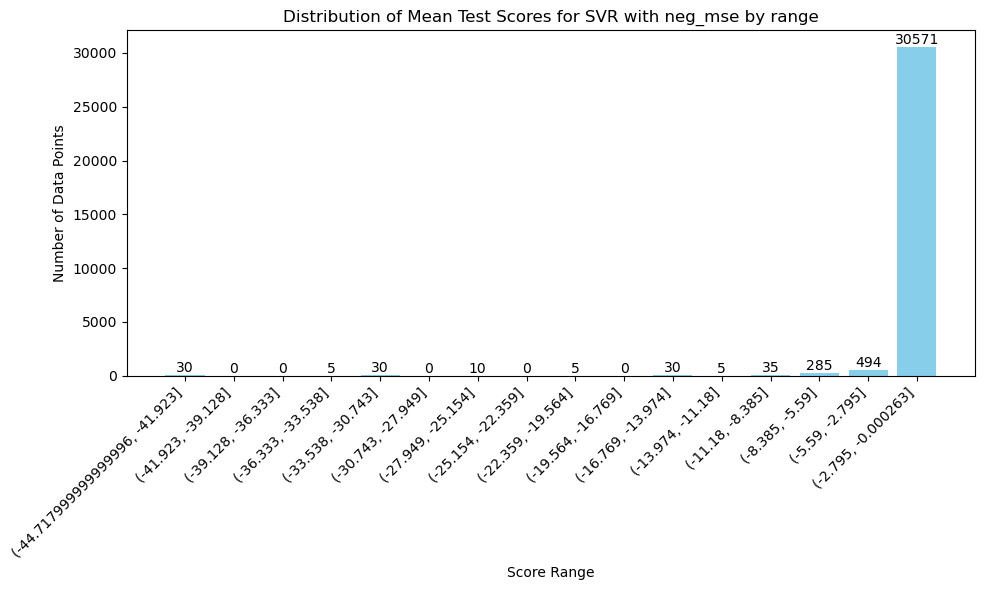

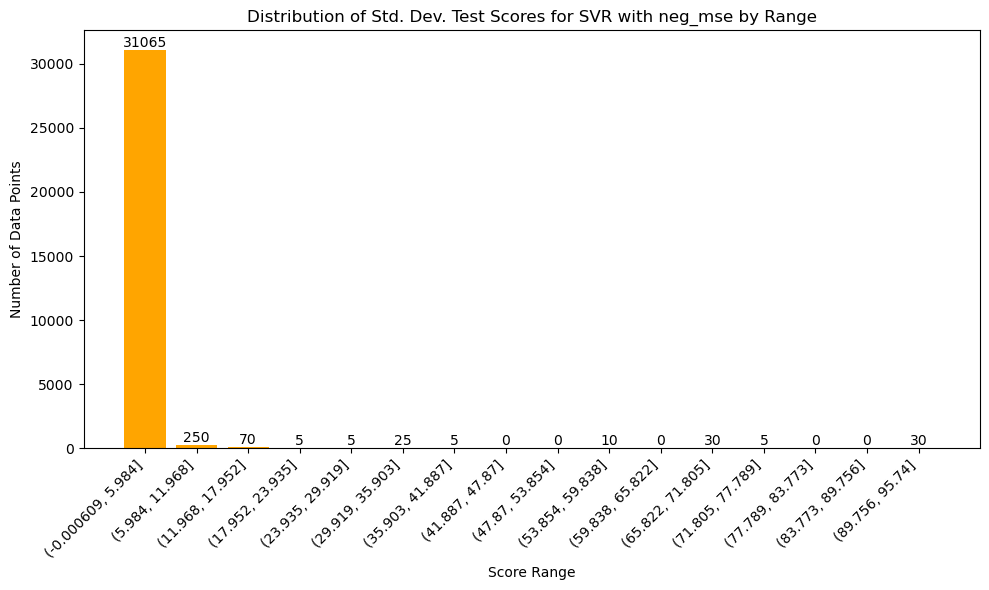

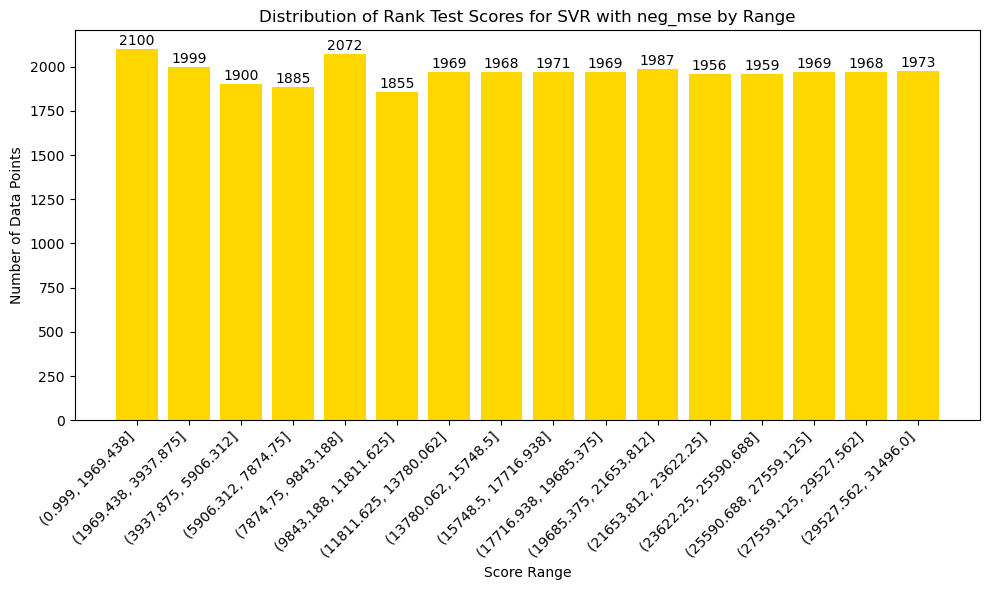

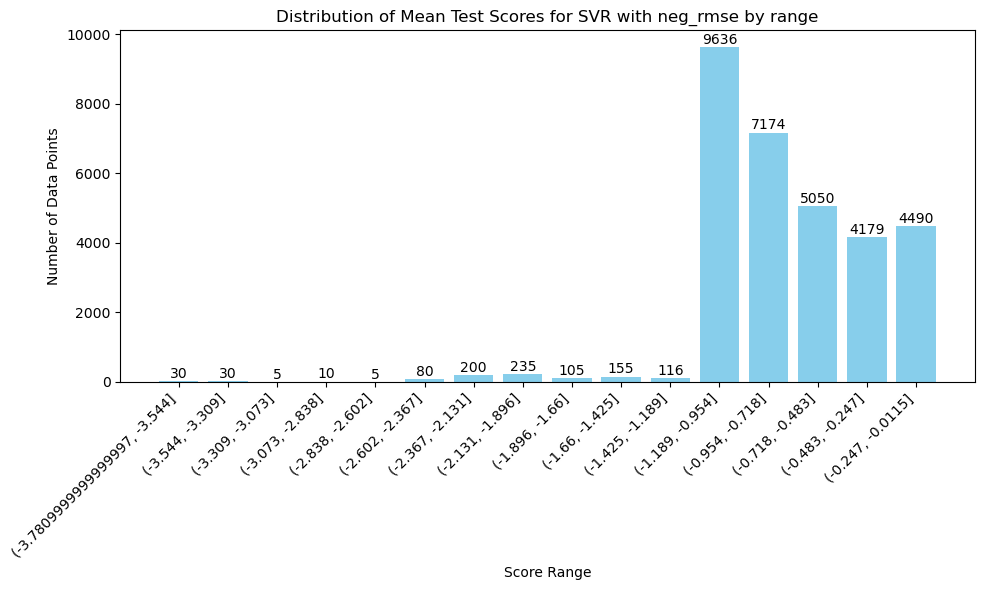

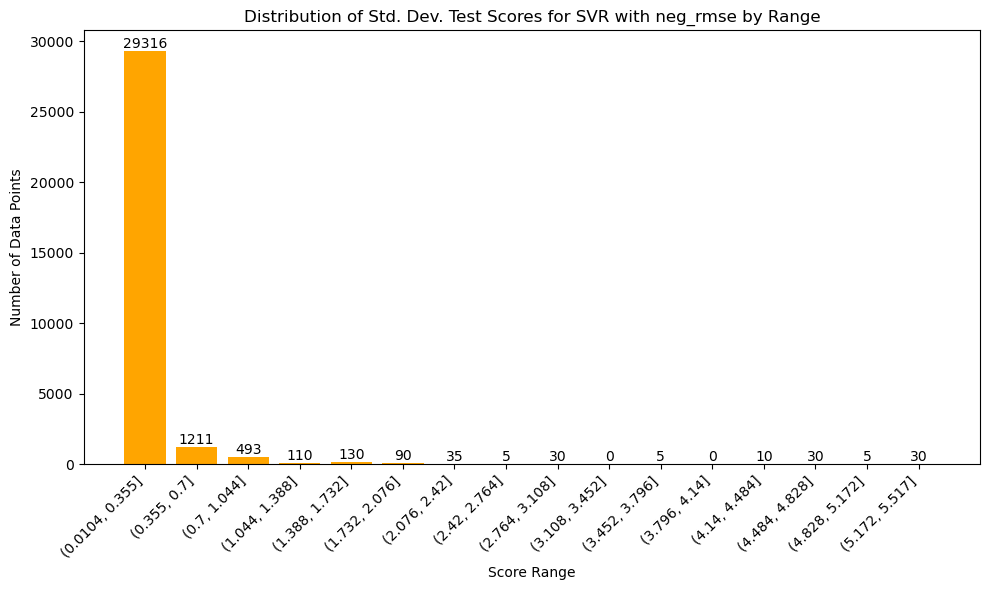

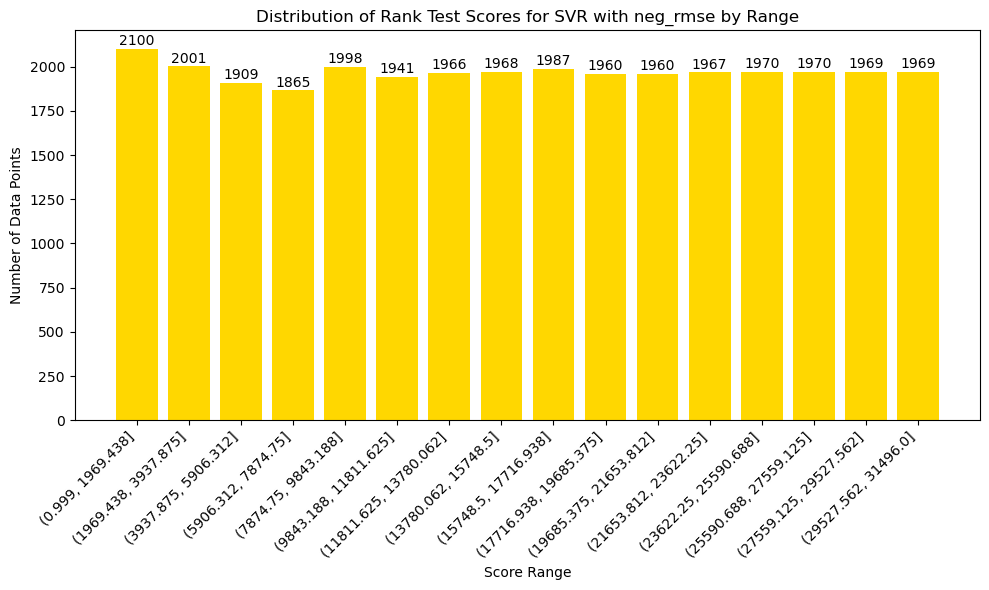

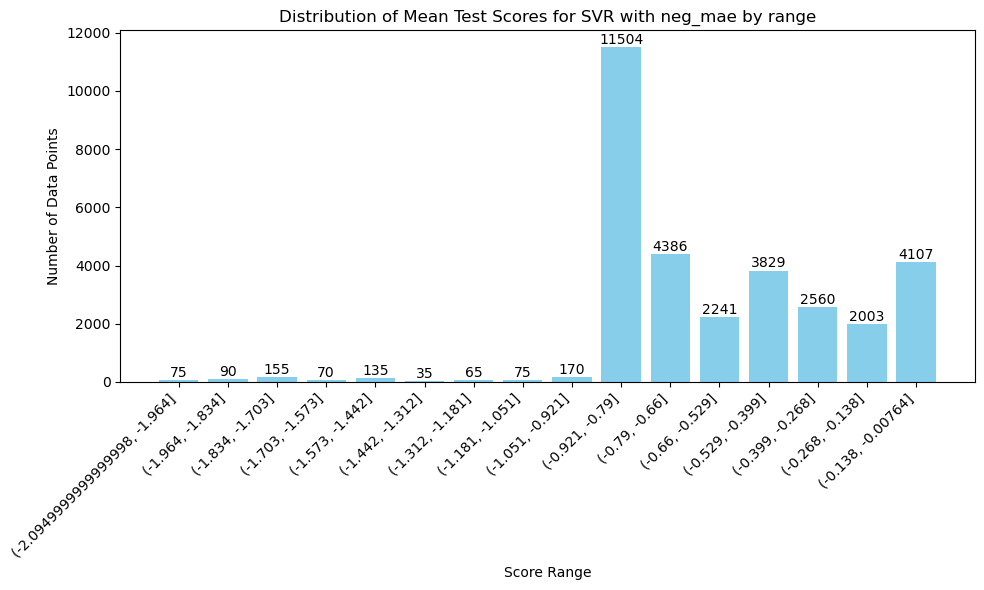

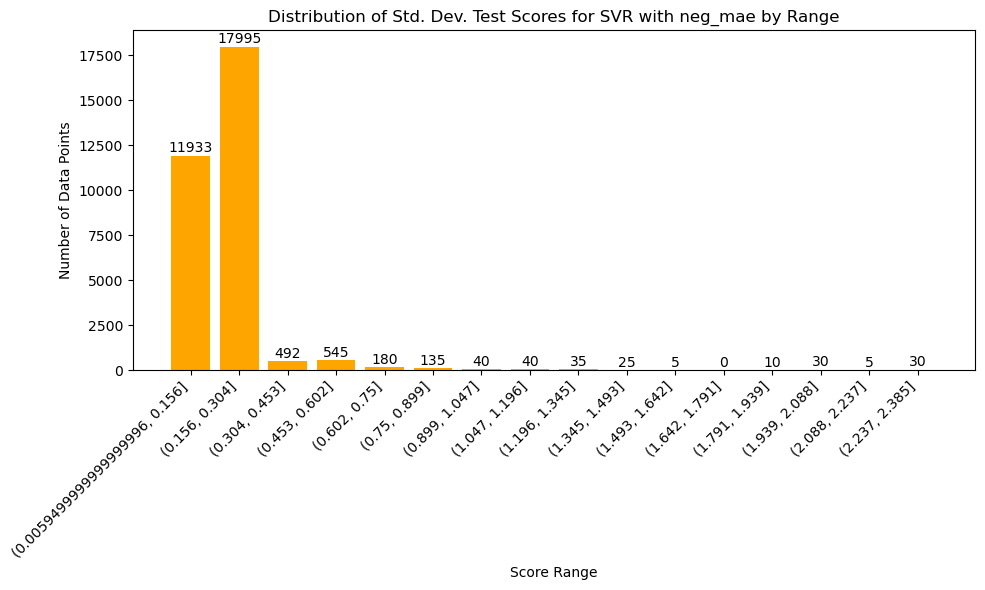

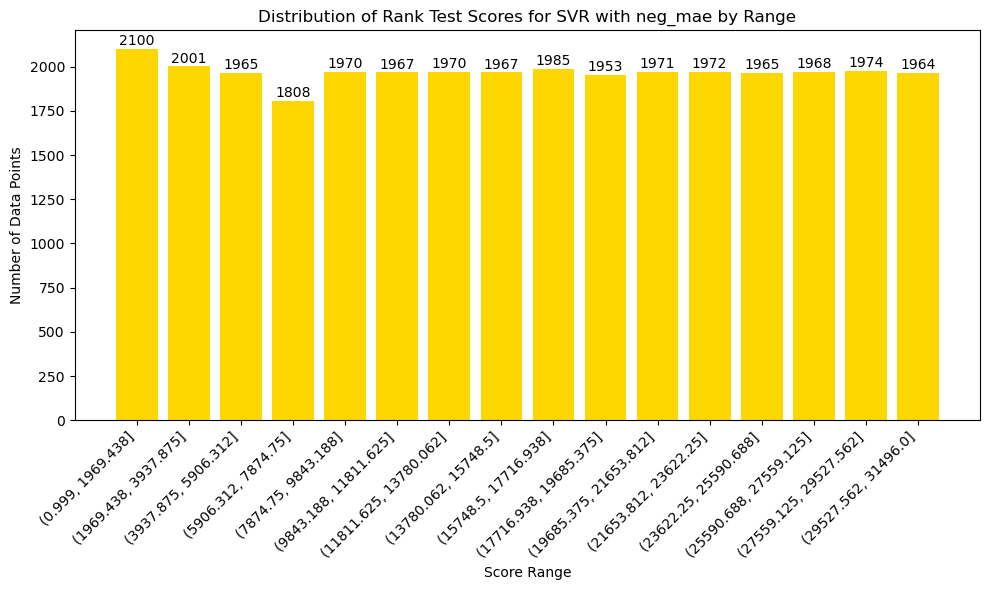

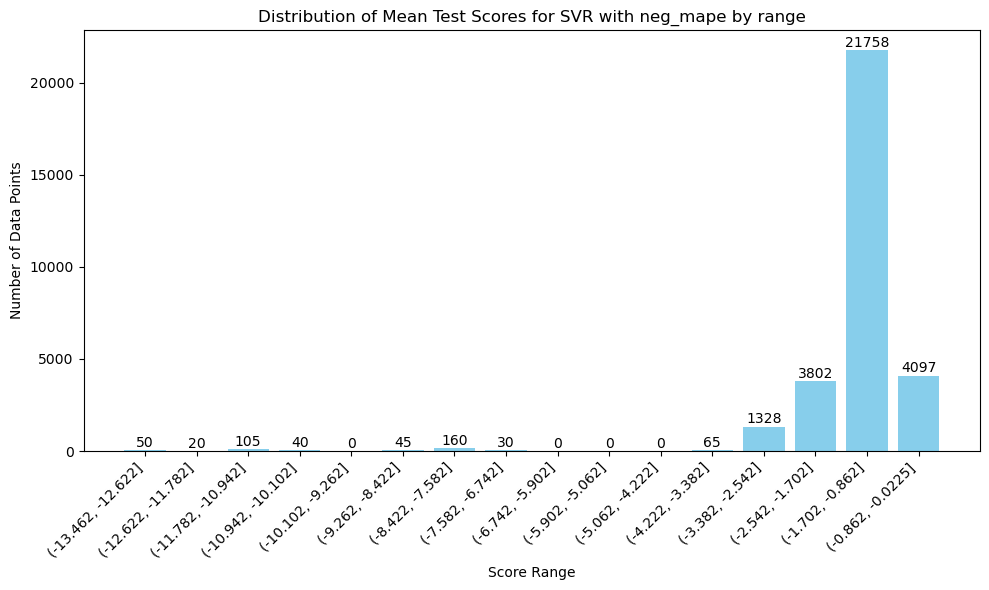

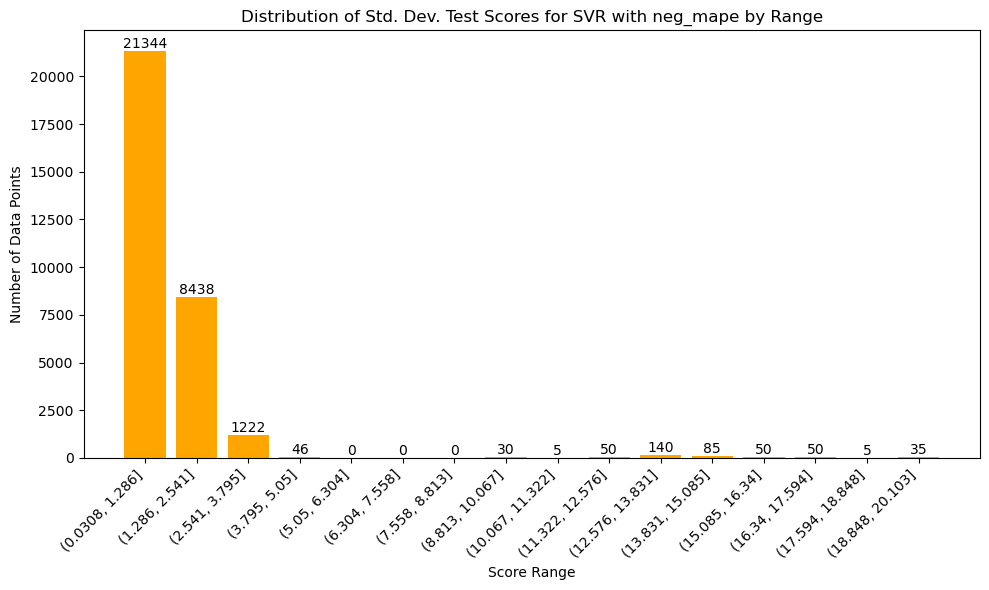

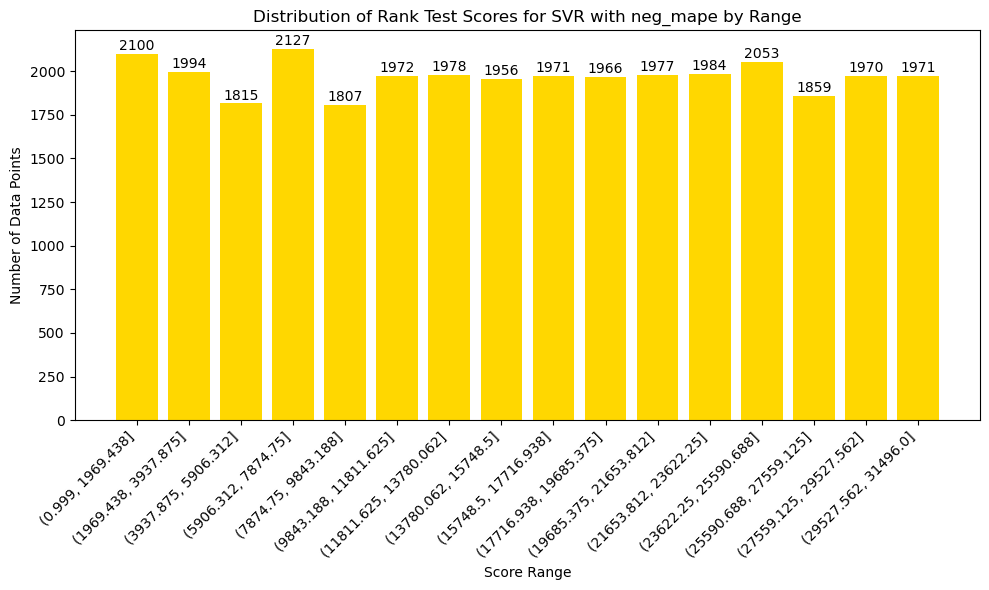

In [108]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# Define the number of bins (ranges) for the score distribution
num_bins = 16 # You can change this to 4 (quarters), 8 (eighths), or any other number

# Iterate through each scoring method
for scoring_name, results in results_svr.items():
	table: pd.DataFrame = results["result_table"]

	mean_test_scores: pd.Series = table["mean_test_score"]
	std_test_scores: pd.Series = table["std_test_score"]
	rank_test_scores: pd.Series = table["rank_test_score"]

	# Calculate the overall minimum and maximum mean test score for this scoring method
	min_score = mean_test_scores.min()
	max_score = mean_test_scores.max()

	# Define the bins (ranges) based on the min and max scores
	# Using np.linspace to create equally spaced bins
	bins = np.linspace(min_score, max_score, num_bins + 1)

	# Use pandas.cut to group the mean scores into the defined bins
	# include_lowest=True ensures that the minimum value is included in the first bin
	score_ranges = pd.cut(mean_test_scores, bins=bins, include_lowest=True, right=True)

	# Count the number of data points in each bin
	# .value_counts() counts the occurrences of each bin, and .sort_index() sorts them by bin
	bin_counts = score_ranges.value_counts().sort_index()

	# Create a figure and axes for the bar chart
	fig, ax = plt.subplots(figsize=(10, 6))

	# Create the bar chart
	# We use the string representation of the intervals for the x-axis labels
	bar_labels = [str(interval) for interval in bin_counts.index]
	bars = ax.bar(bar_labels, bin_counts.values, color='skyblue') # Store the bar objects

	# Add height values on top of each bar
	for bar in bars:
		yval = bar.get_height()
		# Add text annotation slightly above the bar
		ax.text(bar.get_x() + bar.get_width()/2., yval + 5, int(yval), ha='center', va='bottom') # Use int(yval) to display whole numbers

	# Set titles and labels
	ax.set_title(f'Distribution of Mean Test Scores for SVR with {scoring_name} by range')
	ax.set_xlabel('Score Range')
	ax.set_ylabel('Number of Data Points')

	# Rotate x-axis labels if necessary for readability
	plt.xticks(rotation=45, ha='right')

	# Improve layout
	fig.tight_layout()

	# Display the figure
	plt.show(fig)

	fig.savefig(f"figures/SVR_mean_{scoring_name}_range.png")

	# Close the figure
	plt.close(fig)
		
	# Calculate the overall minimum and maximum mean test score for this scoring method
	min_score = std_test_scores.min()
	max_score = std_test_scores.max()

	# Define the bins (ranges) based on the min and max scores
	# Using np.linspace to create equally spaced bins
	bins = np.linspace(min_score, max_score, num_bins + 1)

	# Use pandas.cut to group the std. dev scores into the defined bins
	# include_lowest=True ensures that the minimum value is included in the first bin
	score_ranges = pd.cut(std_test_scores, bins=bins, include_lowest=True, right=True)

	# Count the number of data points in each bin
	# .value_counts() counts the occurrences of each bin, and .sort_index() sorts them by bin
	bin_counts = score_ranges.value_counts().sort_index()

	# Create a figure and axes for the bar chart
	fig, ax = plt.subplots(figsize=(10, 6))

	# Create the bar chart
	# We use the string representation of the intervals for the x-axis labels
	bar_labels = [str(interval) for interval in bin_counts.index]
	bars = ax.bar(bar_labels, bin_counts.values, color='orange') # Store the bar objects

	# Add height values on top of each bar
	for bar in bars:
		yval = bar.get_height()
		# Add text annotation slightly above the bar
		ax.text(bar.get_x() + bar.get_width()/2., yval + 5, int(yval), ha='center', va='bottom') # Use int(yval) to display whole numbers

	# Set titles and labels
	ax.set_title(f'Distribution of Std. Dev. Test Scores for SVR with {scoring_name} by Range')
	ax.set_xlabel('Score Range')
	ax.set_ylabel('Number of Data Points')

	# Rotate x-axis labels if necessary for readability
	plt.xticks(rotation=45, ha='right')

	# Improve layout
	fig.tight_layout()

	# Display the figure
	plt.show(fig)

	fig.savefig(f"figures/SVR_stddev_{scoring_name}_range.png")

	# Close the figure
	plt.close(fig)

	# Calculate the overall minimum and maximum mean test score for this scoring method
	min_score = rank_test_scores.min()
	max_score = rank_test_scores.max()

	bins = np.linspace(min_score, max_score, num_bins + 1)

	score_ranges = pd.cut(rank_test_scores, bins=bins, include_lowest=True, right=True)

	bin_counts = score_ranges.value_counts().sort_index()

	fig, ax = plt.subplots(figsize=(10, 6))

	bar_labels = [str(interval) for interval in bin_counts.index]
	bars = ax.bar(bar_labels, bin_counts.values, color='gold') # Store the bar objects

	# Add height values on top of each bar
	for bar in bars:
		yval = bar.get_height()
		# Add text annotation slightly above the bar
		ax.text(bar.get_x() + bar.get_width()/2., yval + 5, int(yval), ha='center', va='bottom') # Use int(yval) to display whole numbers

	# Set titles and labels
	ax.set_title(f'Distribution of Rank Test Scores for SVR with {scoring_name} by Range')
	ax.set_xlabel('Score Range')
	ax.set_ylabel('Number of Data Points')

	# Rotate x-axis labels if necessary for readability
	plt.xticks(rotation=45, ha='right')

	# Improve layout
	fig.tight_layout()

	# Display the figure
	plt.show(fig)

	fig.savefig(f"figures/SVR_rank_{scoring_name}_range.png")

	# Close the figure
	plt.close(fig)
		
	# Clean up variables
	del table
	del mean_test_scores
	del fig
	del ax



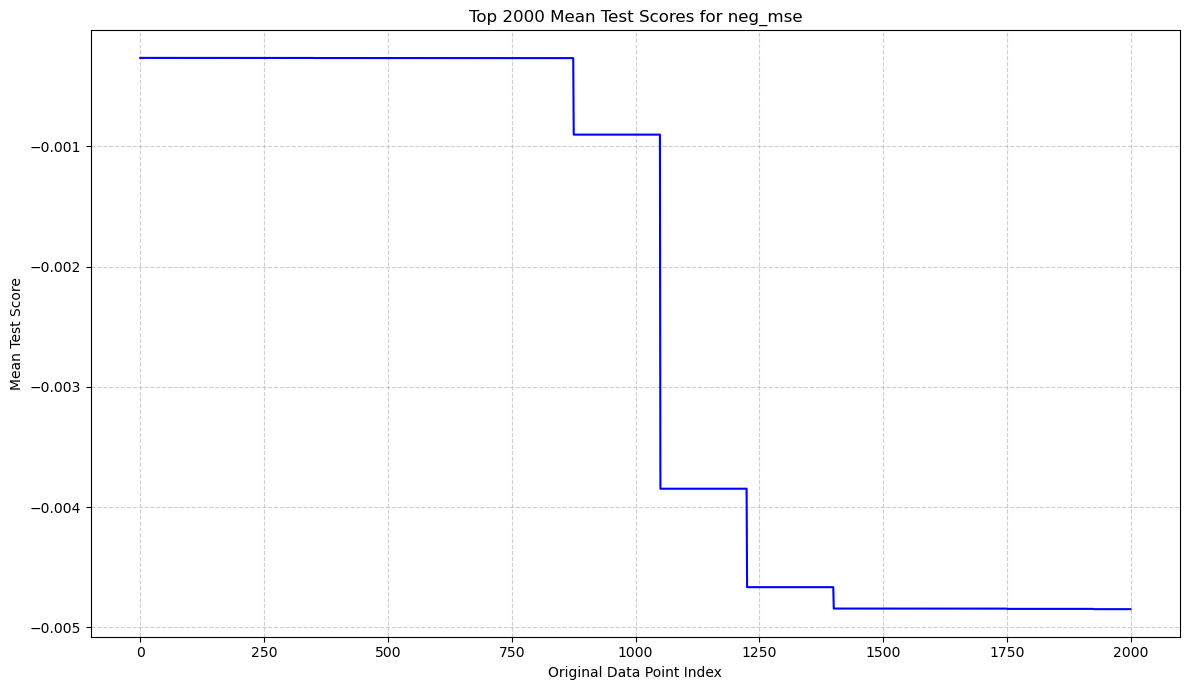

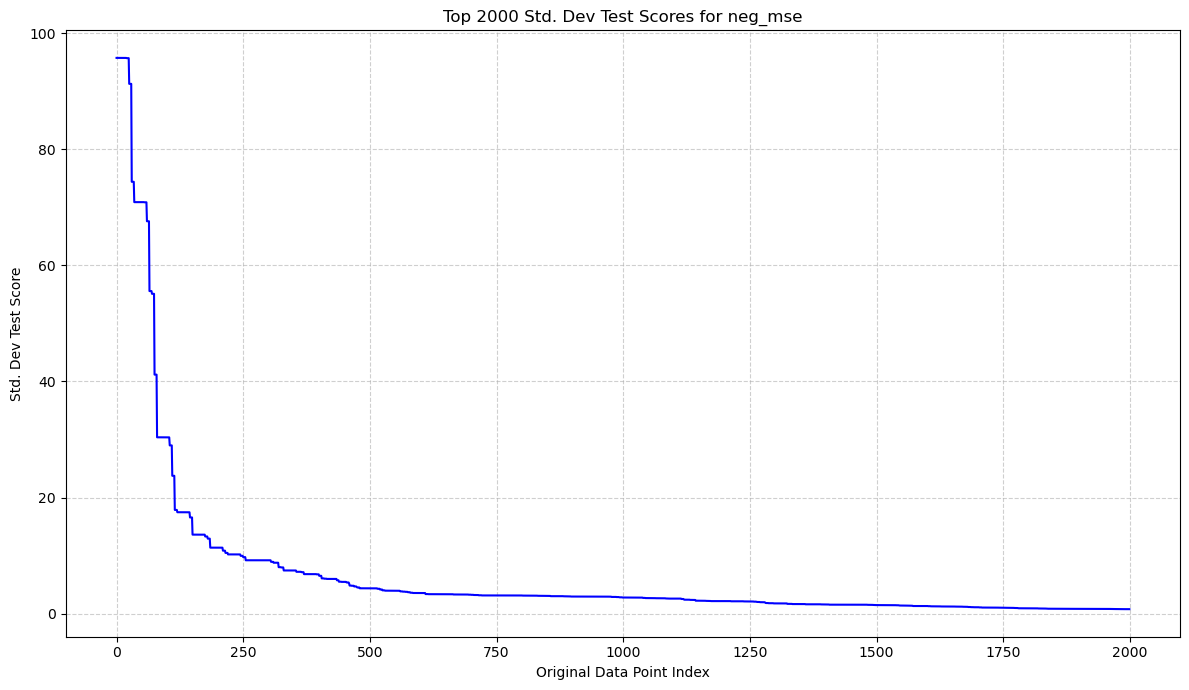

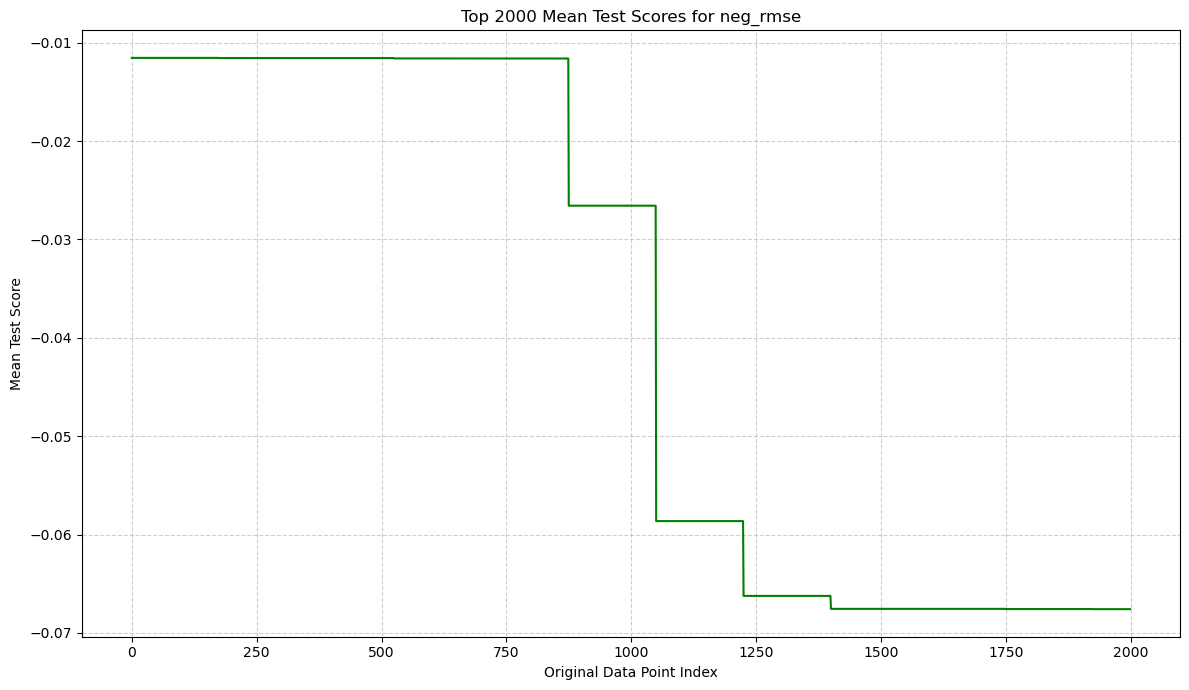

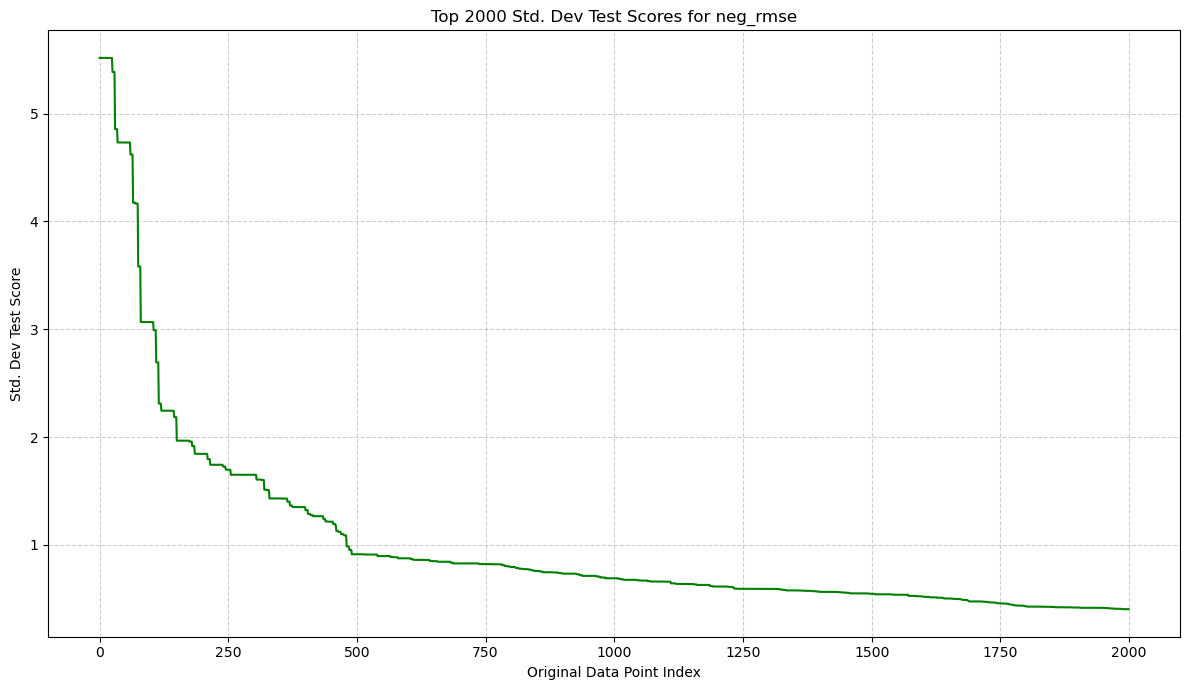

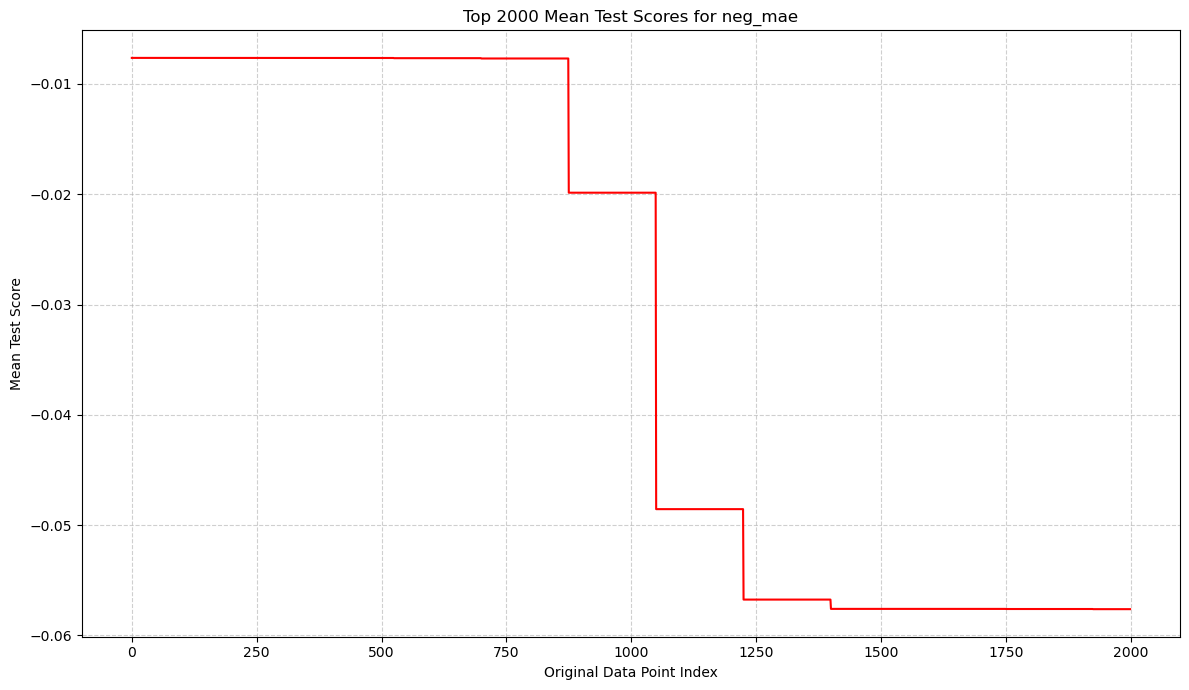

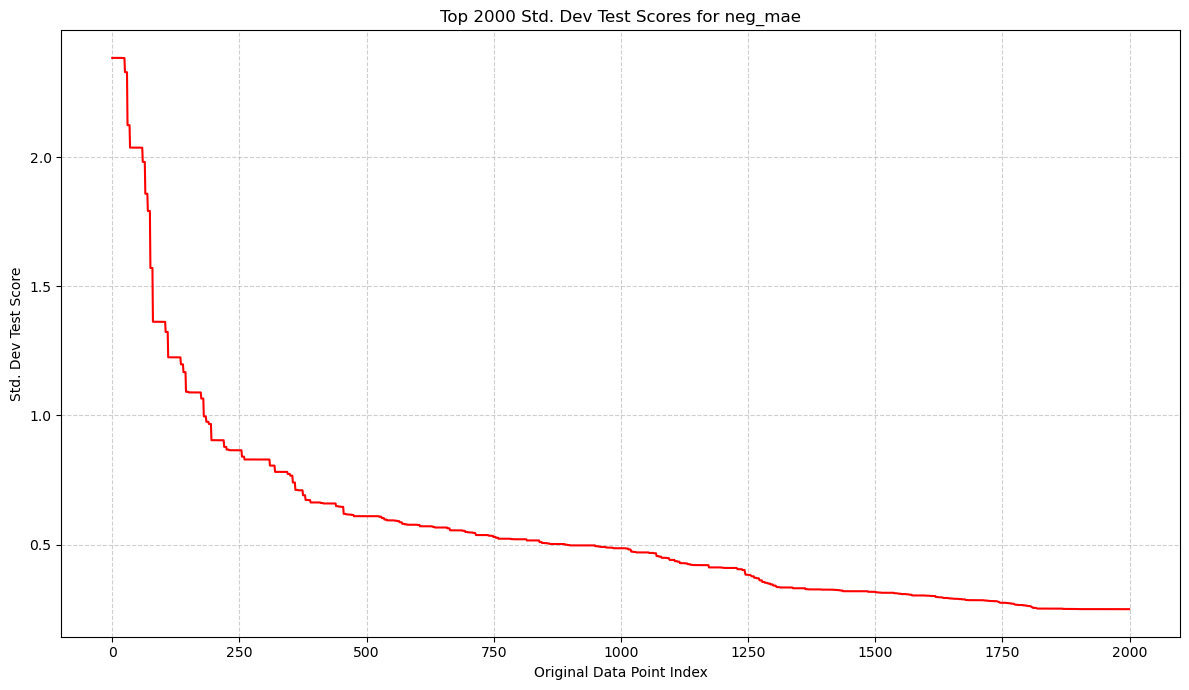

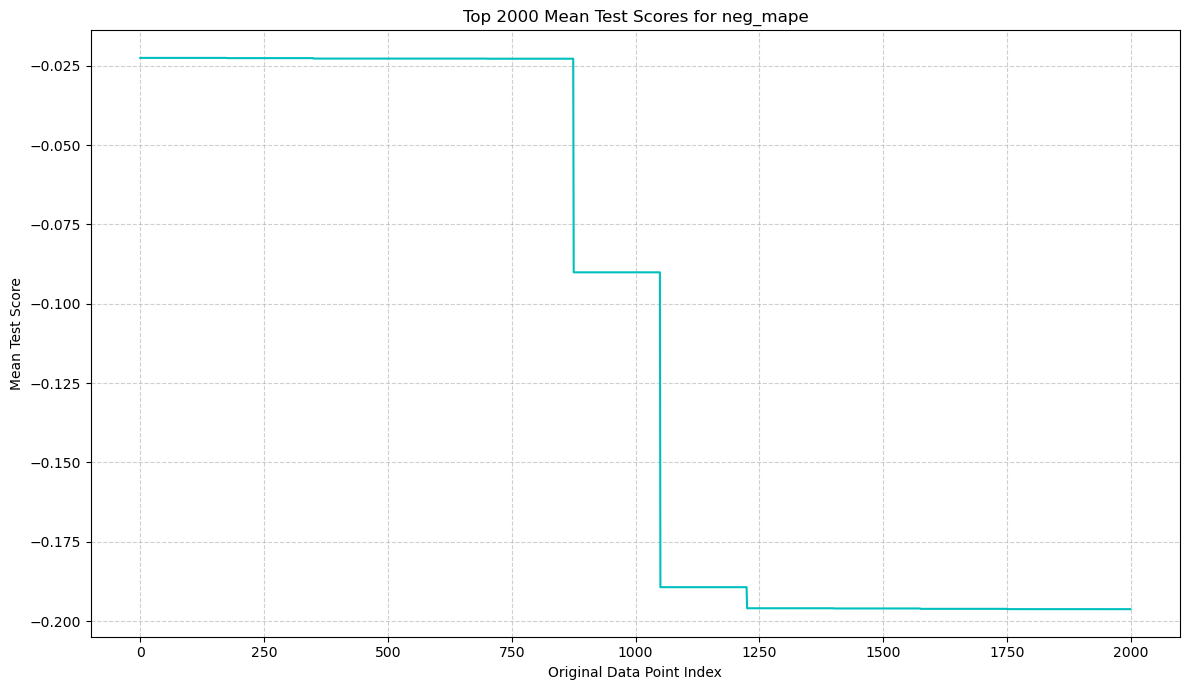

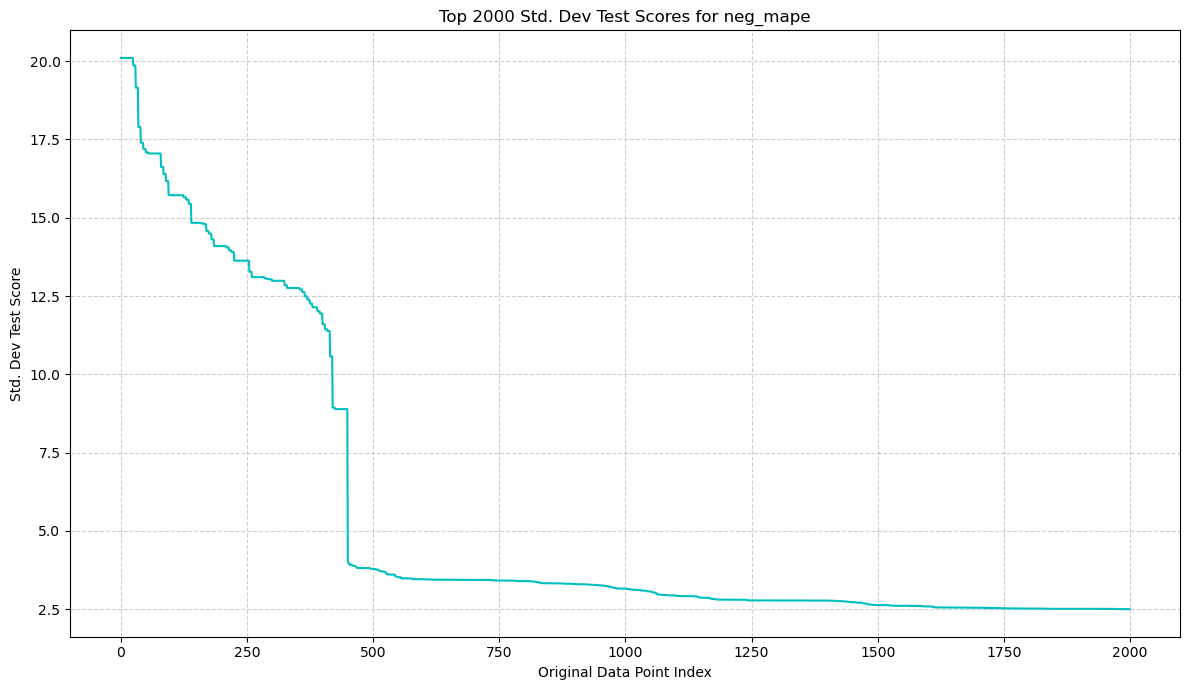

In [112]:
num_top_values = 2000
colors: list[str] = ["b", "g", "r", "c", "tab:orange", "tab:purple", "tab:brown", "lime", "gold"]

plot_names = ["Mean", "Std. Dev", "Rank"] 

# Iterate through each scoring method
for i, (scoring_name, results) in enumerate(results_svr.items()):
	table: pd.DataFrame = results["result_table"]

	mean_test_scores: pd.Series = table["mean_test_score"]
	std_test_scores: pd.Series = table["std_test_score"]
	
	test_scores: list[pd.Series] = [mean_test_scores, std_test_scores]
	for j, test_score in enumerate(test_scores):
		# Sort the mean test scores in descending order and select the top N values
		# .sort_values(ascending=False) sorts the Series
		# .head(num_top_values) selects the top N values
		top_scores = test_score.sort_values(ascending=False).head(num_top_values)

		# Create a figure and axes for the line plot
		fig, ax = plt.subplots(figsize=(12, 7))

		# Plot the top mean scores as a line graph
		# The x-axis will be the original index of these top scores
		color = colors[i % len(colors)] # Cycle through colors for different scoring methods
		ax.plot(top_scores.values, color=color)

		# Set titles and labels
		ax.set_title(f'Top {num_top_values} {plot_names[j]} Test Scores for {scoring_name}')
		ax.set_xlabel('Original Data Point Index')
		ax.set_ylabel(f'{plot_names[j]} Test Score')

		# Add a grid for better readability
		ax.grid(True, linestyle='--', alpha=0.6)

		# Improve layout
		fig.tight_layout()

		# Display the figure
		plt.show(fig)

		fig.savefig(f"figures/SVR_top_{num_top_values}_{plot_names[j].lower()}_{scoring_name}_point.png")

		# Close the figure
		plt.close(fig)

	# Clean up variables
	del table
	del mean_test_scores
	del std_test_scores
	del top_scores
	del fig
	del ax

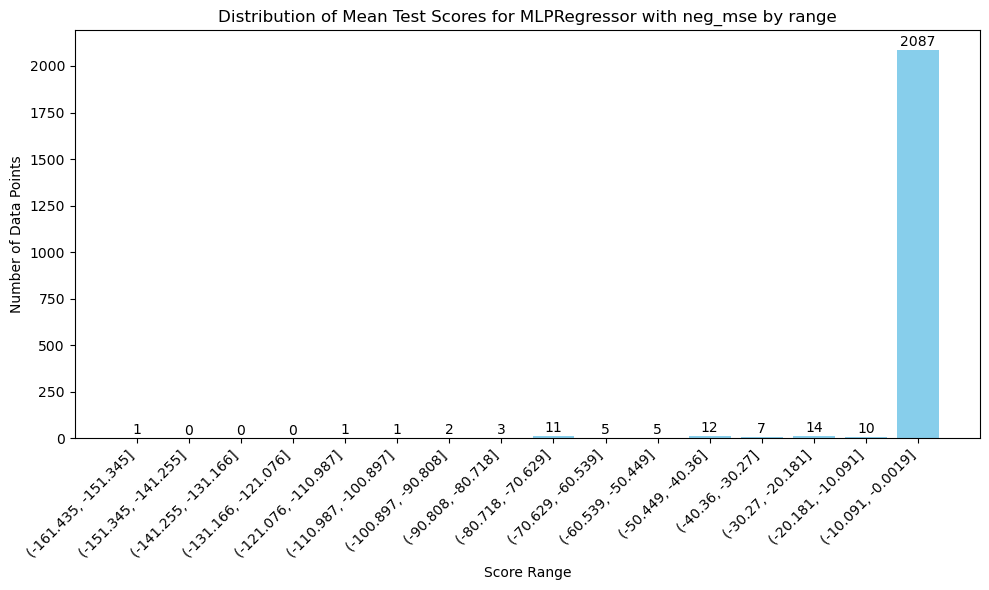

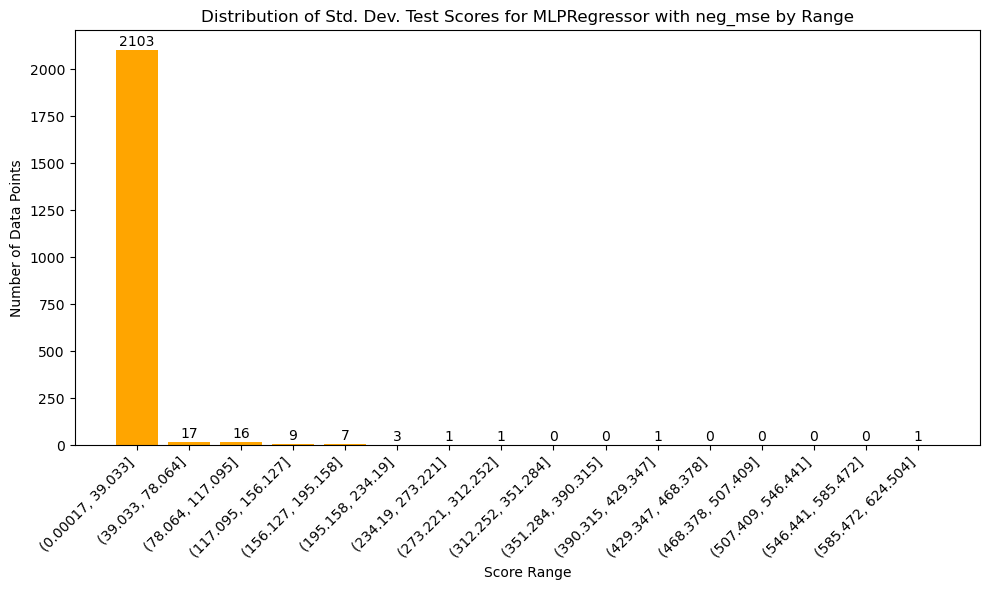

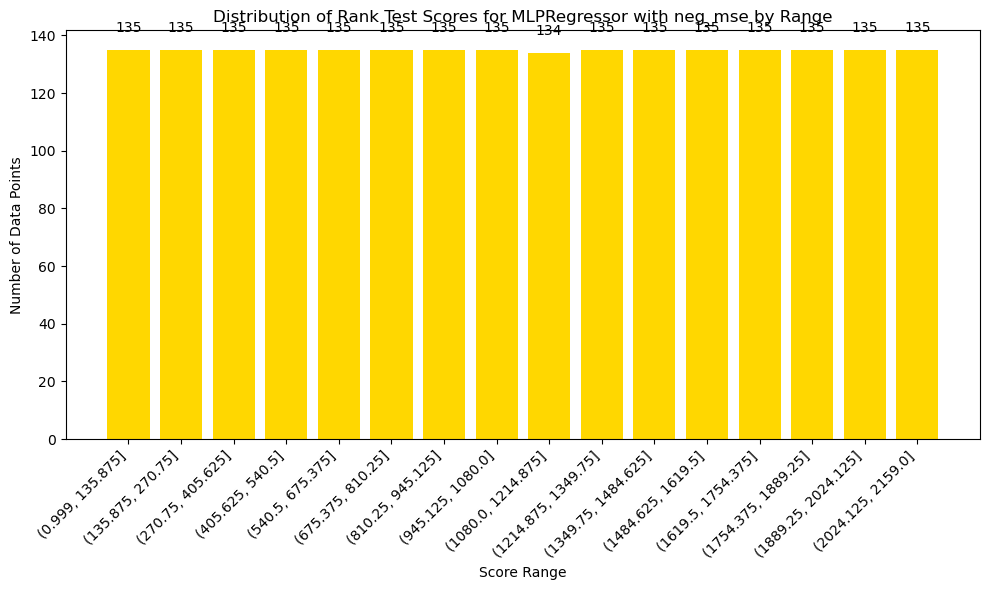

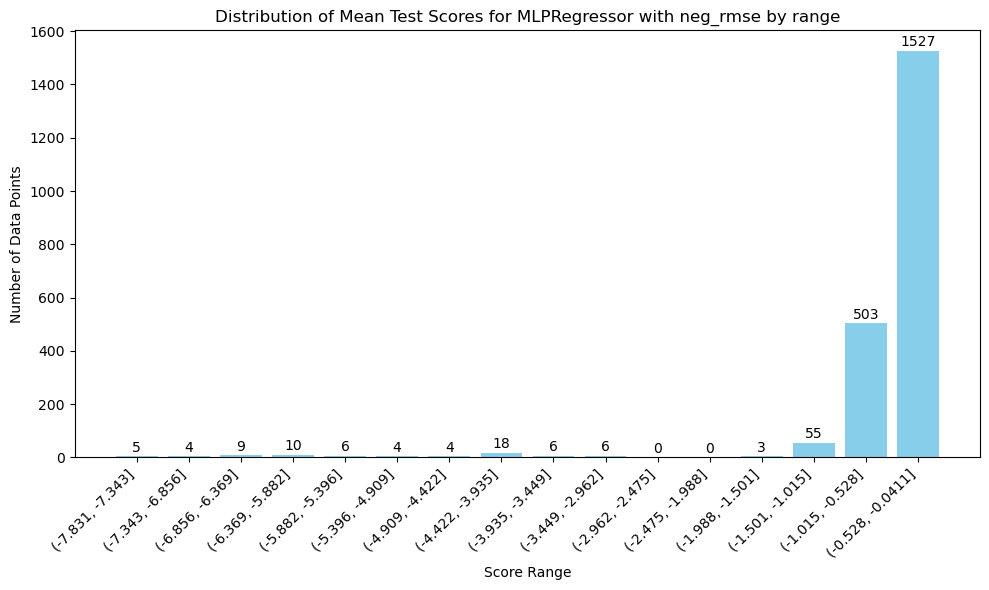

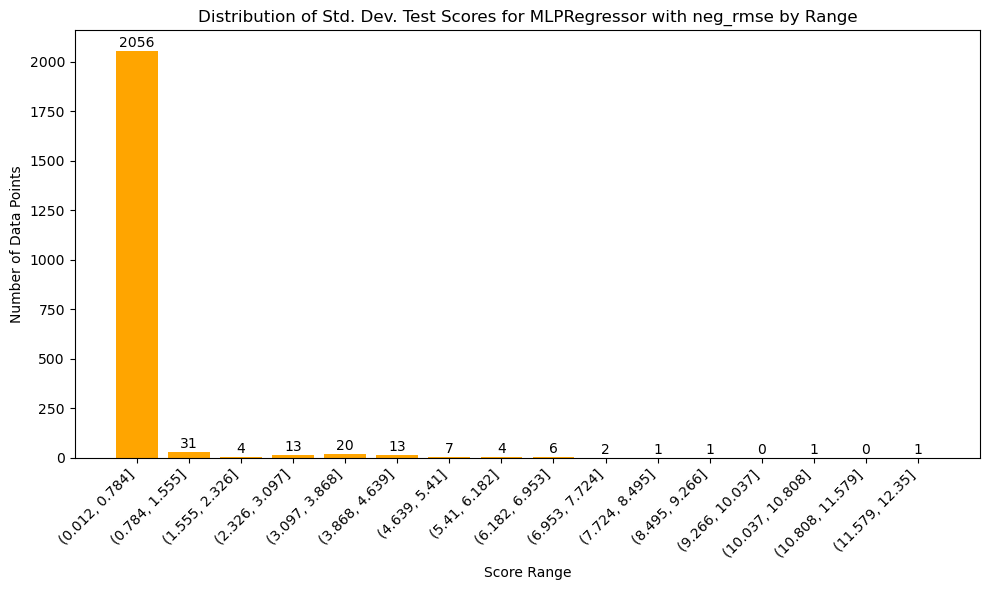

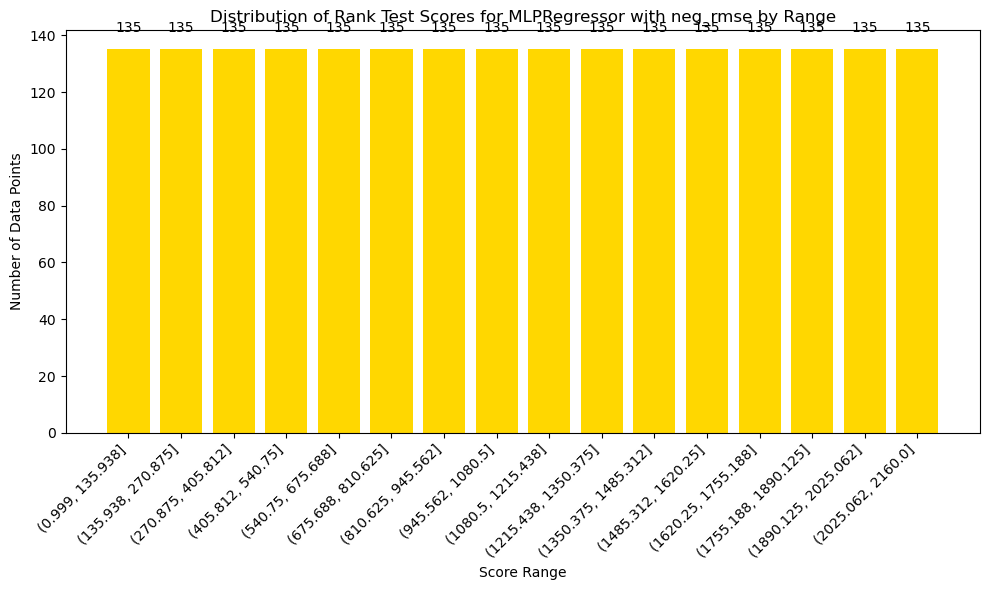

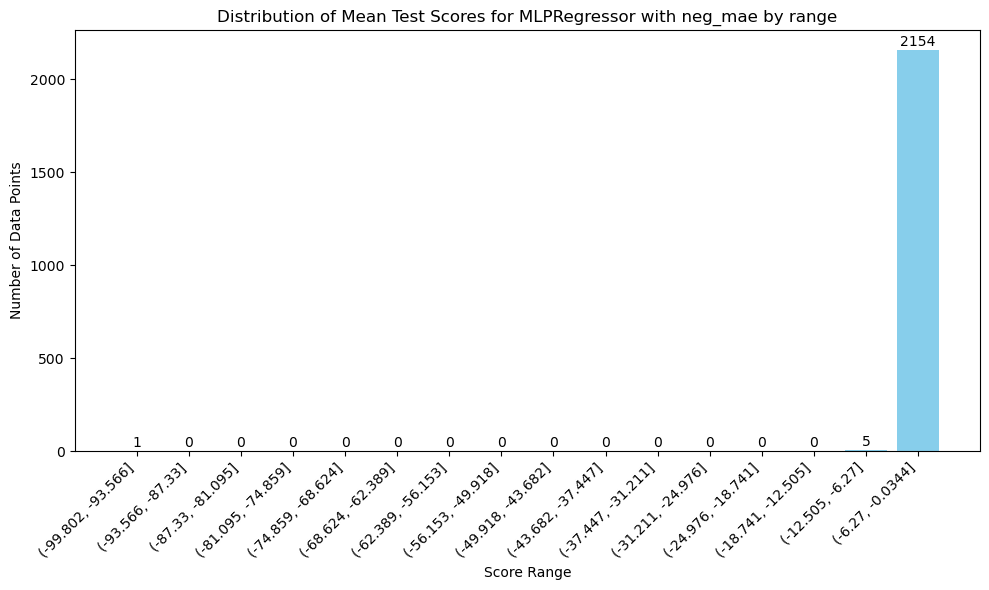

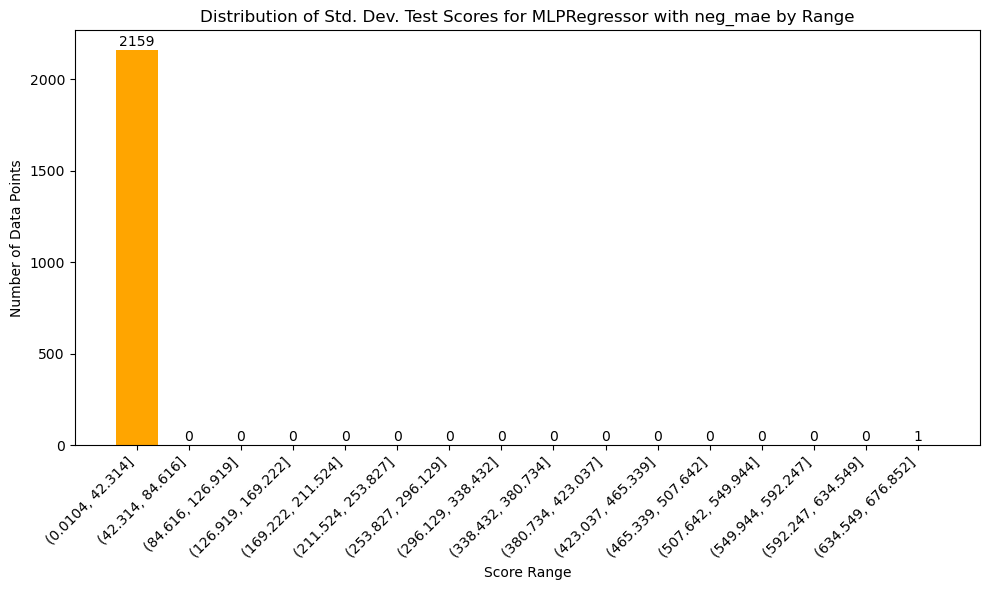

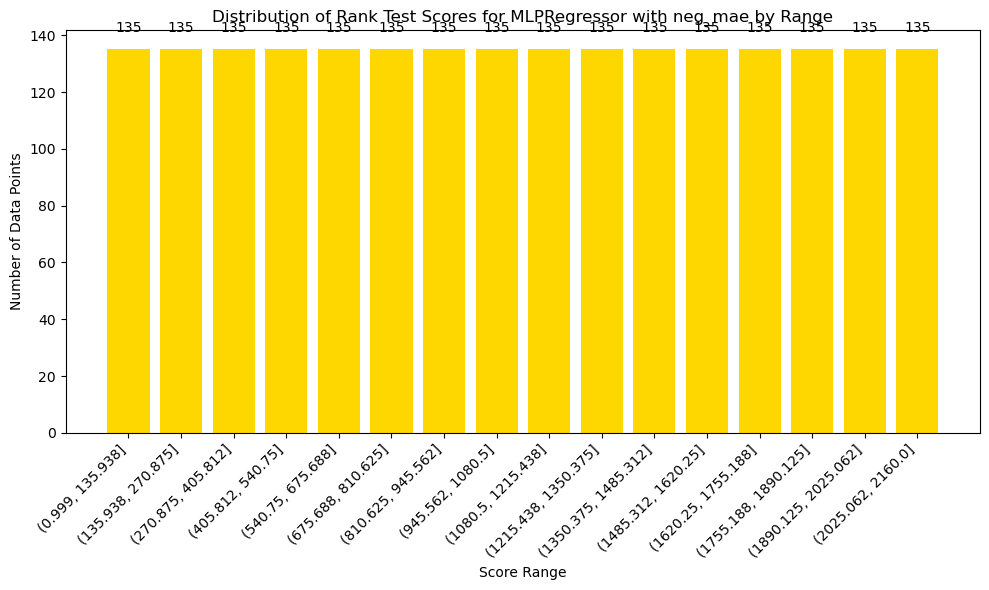

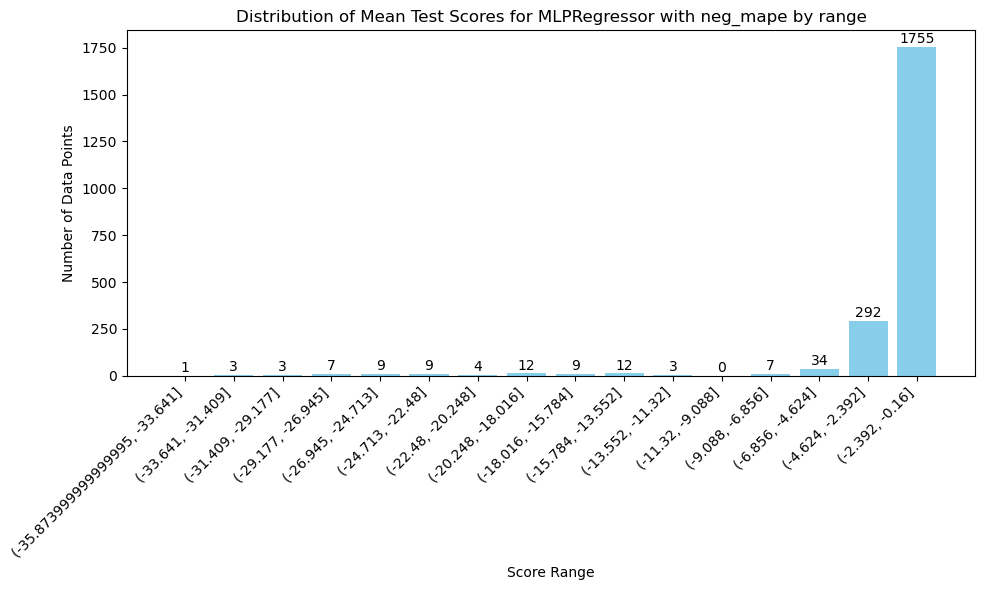

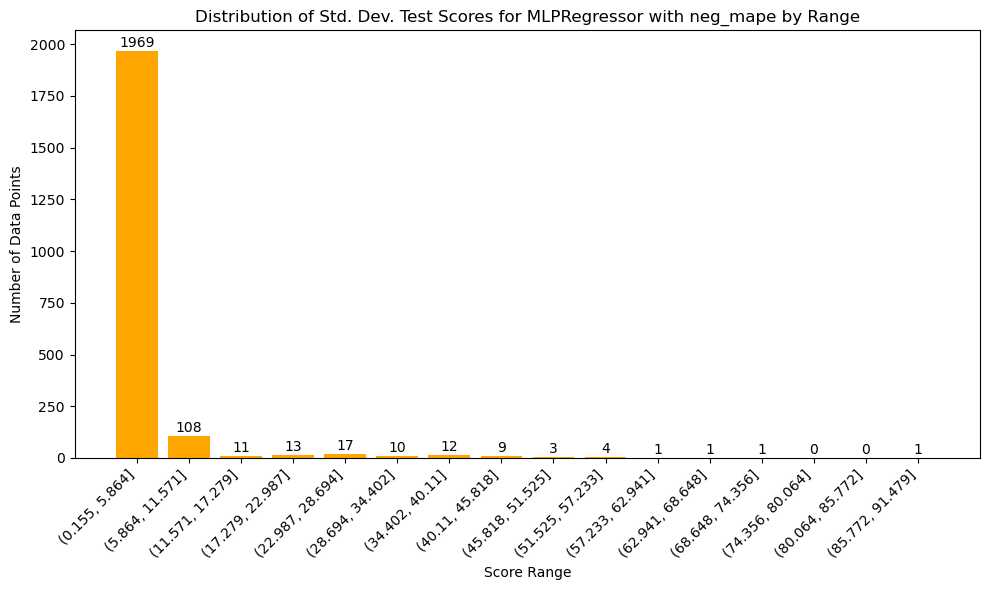

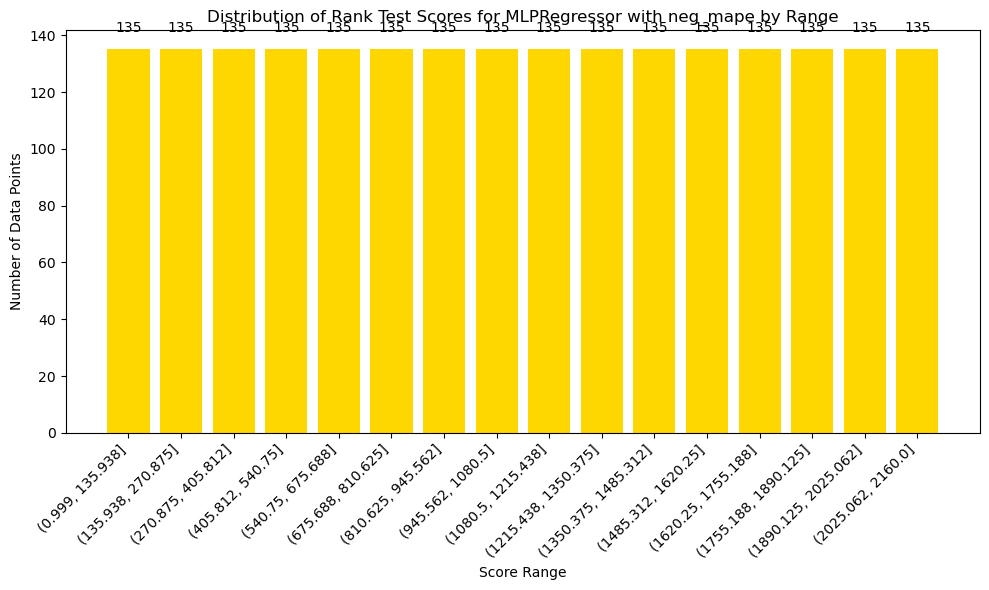

In [113]:
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes

# Define the number of bins (ranges) for the score distribution
num_bins = 16 # You can change this to 4 (quarters), 8 (eighths), or any other number

# Iterate through each scoring method
for scoring_name, results in results_mlp.items():
	table: pd.DataFrame = results["result_table"]

	mean_test_scores: pd.Series = table["mean_test_score"]
	std_test_scores: pd.Series = table["std_test_score"]
	rank_test_scores: pd.Series = table["rank_test_score"]

	# Calculate the overall minimum and maximum mean test score for this scoring method
	min_score = mean_test_scores.min()
	max_score = mean_test_scores.max()

	# Define the bins (ranges) based on the min and max scores
	# Using np.linspace to create equally spaced bins
	bins = np.linspace(min_score, max_score, num_bins + 1)

	# Use pandas.cut to group the mean scores into the defined bins
	# include_lowest=True ensures that the minimum value is included in the first bin
	score_ranges = pd.cut(mean_test_scores, bins=bins, include_lowest=True, right=True)

	# Count the number of data points in each bin
	# .value_counts() counts the occurrences of each bin, and .sort_index() sorts them by bin
	bin_counts = score_ranges.value_counts().sort_index()

	# Create a figure and axes for the bar chart
	fig, ax = plt.subplots(figsize=(10, 6))

	# Create the bar chart
	# We use the string representation of the intervals for the x-axis labels
	bar_labels = [str(interval) for interval in bin_counts.index]
	bars = ax.bar(bar_labels, bin_counts.values, color='skyblue') # Store the bar objects

	# Add height values on top of each bar
	for bar in bars:
		yval = bar.get_height()
		# Add text annotation slightly above the bar
		ax.text(bar.get_x() + bar.get_width()/2., yval + 5, int(yval), ha='center', va='bottom') # Use int(yval) to display whole numbers

	# Set titles and labels
	ax.set_title(f'Distribution of Mean Test Scores for MLPRegressor with {scoring_name} by range')
	ax.set_xlabel('Score Range')
	ax.set_ylabel('Number of Data Points')

	# Rotate x-axis labels if necessary for readability
	plt.xticks(rotation=45, ha='right')

	# Improve layout
	fig.tight_layout()

	# Display the figure
	plt.show(fig)

	fig.savefig(f"figures/MLPRegressor_mean_{scoring_name}_range.png")

	# Close the figure
	plt.close(fig)
		
	# Calculate the overall minimum and maximum mean test score for this scoring method
	min_score = std_test_scores.min()
	max_score = std_test_scores.max()

	# Define the bins (ranges) based on the min and max scores
	# Using np.linspace to create equally spaced bins
	bins = np.linspace(min_score, max_score, num_bins + 1)

	# Use pandas.cut to group the std. dev scores into the defined bins
	# include_lowest=True ensures that the minimum value is included in the first bin
	score_ranges = pd.cut(std_test_scores, bins=bins, include_lowest=True, right=True)

	# Count the number of data points in each bin
	# .value_counts() counts the occurrences of each bin, and .sort_index() sorts them by bin
	bin_counts = score_ranges.value_counts().sort_index()

	# Create a figure and axes for the bar chart
	fig, ax = plt.subplots(figsize=(10, 6))

	# Create the bar chart
	# We use the string representation of the intervals for the x-axis labels
	bar_labels = [str(interval) for interval in bin_counts.index]
	bars = ax.bar(bar_labels, bin_counts.values, color='orange') # Store the bar objects

	# Add height values on top of each bar
	for bar in bars:
		yval = bar.get_height()
		# Add text annotation slightly above the bar
		ax.text(bar.get_x() + bar.get_width()/2., yval + 5, int(yval), ha='center', va='bottom') # Use int(yval) to display whole numbers

	# Set titles and labels
	ax.set_title(f'Distribution of Std. Dev. Test Scores for MLPRegressor with {scoring_name} by Range')
	ax.set_xlabel('Score Range')
	ax.set_ylabel('Number of Data Points')

	# Rotate x-axis labels if necessary for readability
	plt.xticks(rotation=45, ha='right')

	# Improve layout
	fig.tight_layout()

	# Display the figure
	plt.show(fig)

	fig.savefig(f"figures/MLPRegressor_stddev_{scoring_name}_range.png")

	# Close the figure
	plt.close(fig)

	# Calculate the overall minimum and maximum mean test score for this scoring method
	min_score = rank_test_scores.min()
	max_score = rank_test_scores.max()

	bins = np.linspace(min_score, max_score, num_bins + 1)

	score_ranges = pd.cut(rank_test_scores, bins=bins, include_lowest=True, right=True)

	bin_counts = score_ranges.value_counts().sort_index()

	fig, ax = plt.subplots(figsize=(10, 6))

	bar_labels = [str(interval) for interval in bin_counts.index]
	bars = ax.bar(bar_labels, bin_counts.values, color='gold') # Store the bar objects

	# Add height values on top of each bar
	for bar in bars:
		yval = bar.get_height()
		# Add text annotation slightly above the bar
		ax.text(bar.get_x() + bar.get_width()/2., yval + 5, int(yval), ha='center', va='bottom') # Use int(yval) to display whole numbers

	# Set titles and labels
	ax.set_title(f'Distribution of Rank Test Scores for MLPRegressor with {scoring_name} by Range')
	ax.set_xlabel('Score Range')
	ax.set_ylabel('Number of Data Points')

	# Rotate x-axis labels if necessary for readability
	plt.xticks(rotation=45, ha='right')

	# Improve layout
	fig.tight_layout()

	# Display the figure
	plt.show(fig)

	fig.savefig(f"figures/MLPRegressor_rank_{scoring_name}_range.png")

	# Close the figure
	plt.close(fig)
		
	# Clean up variables
	del table
	del mean_test_scores
	del fig
	del ax



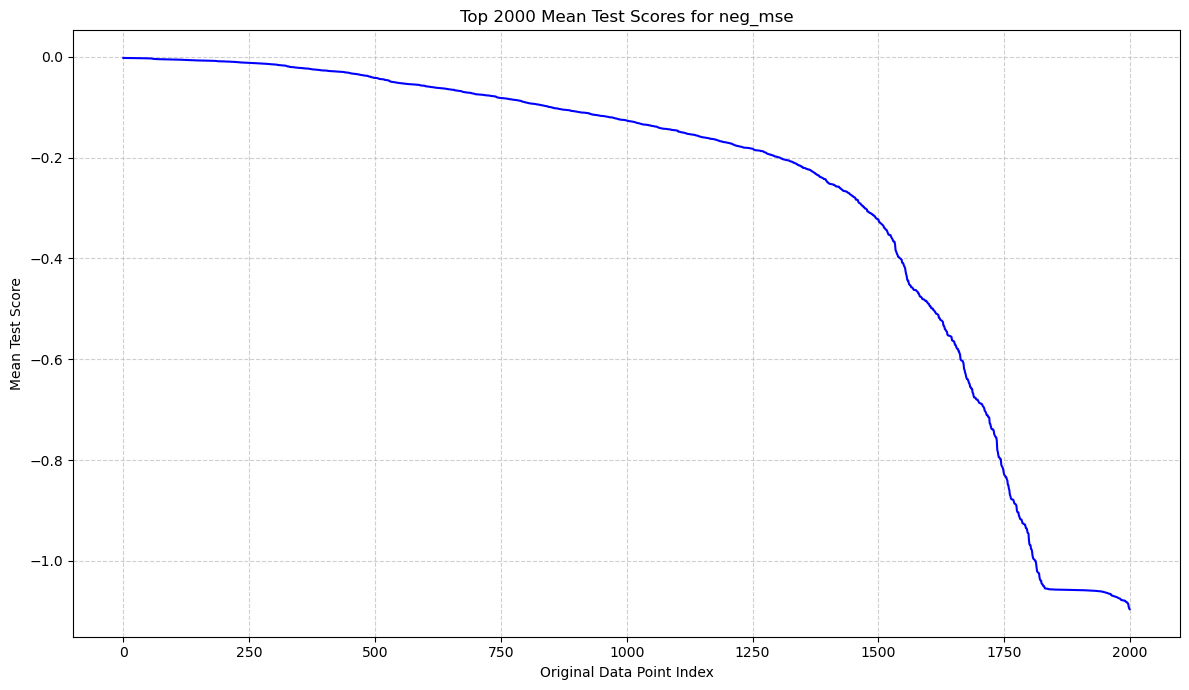

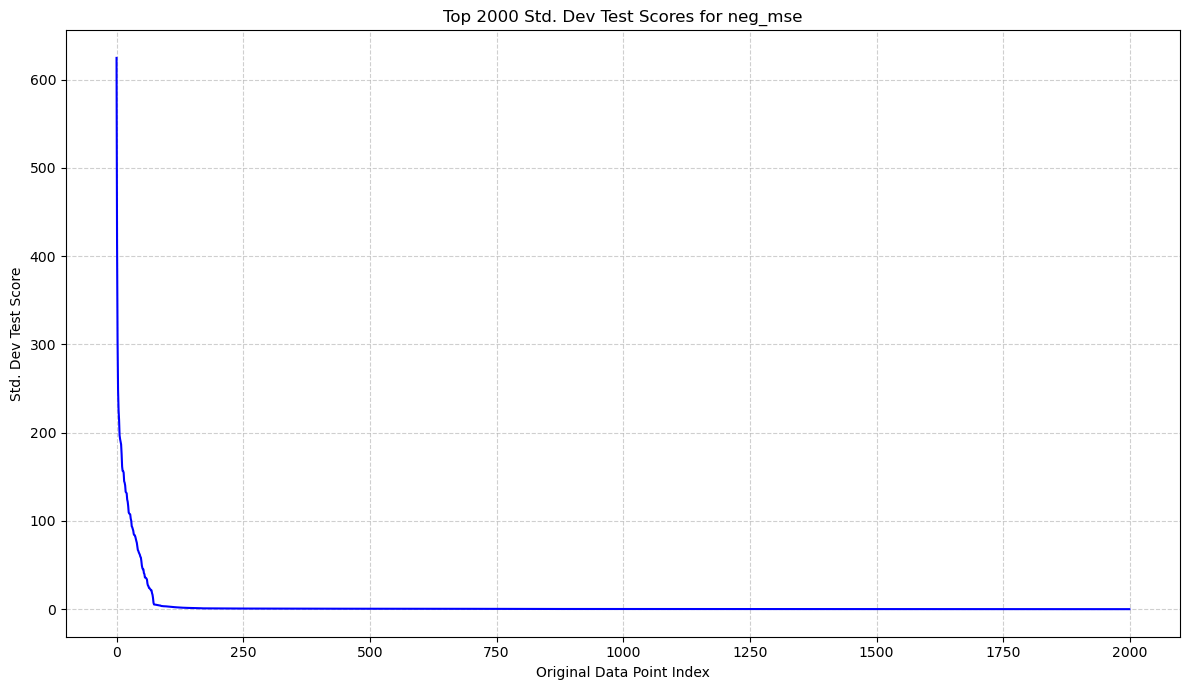

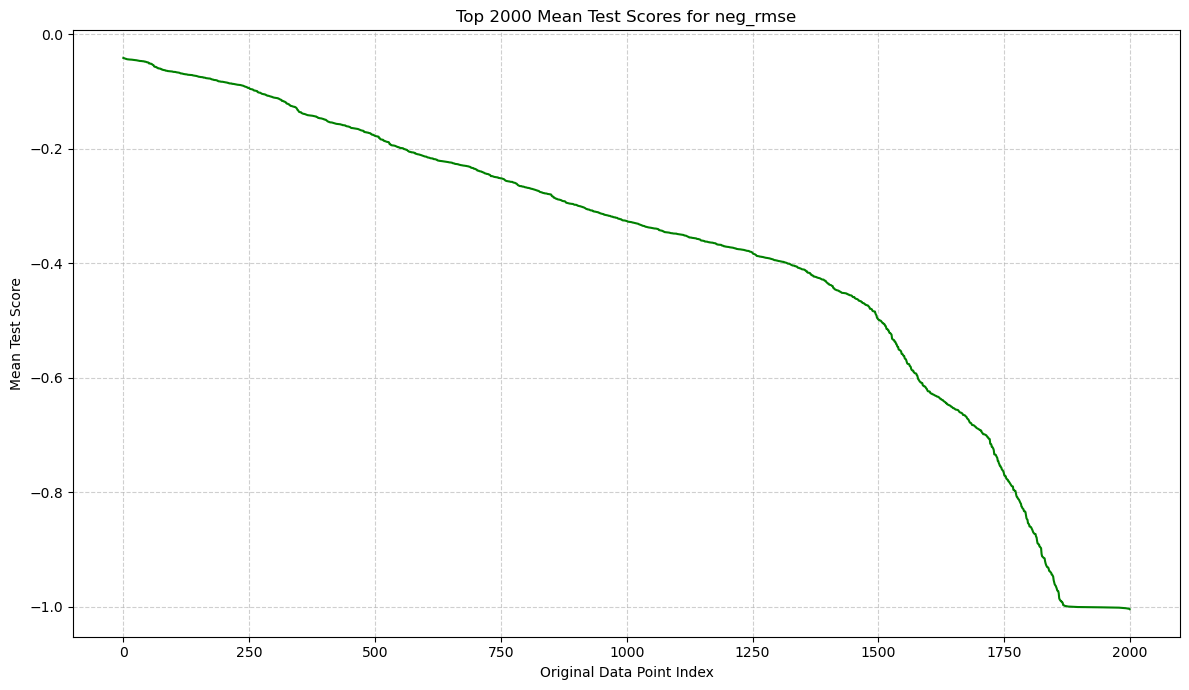

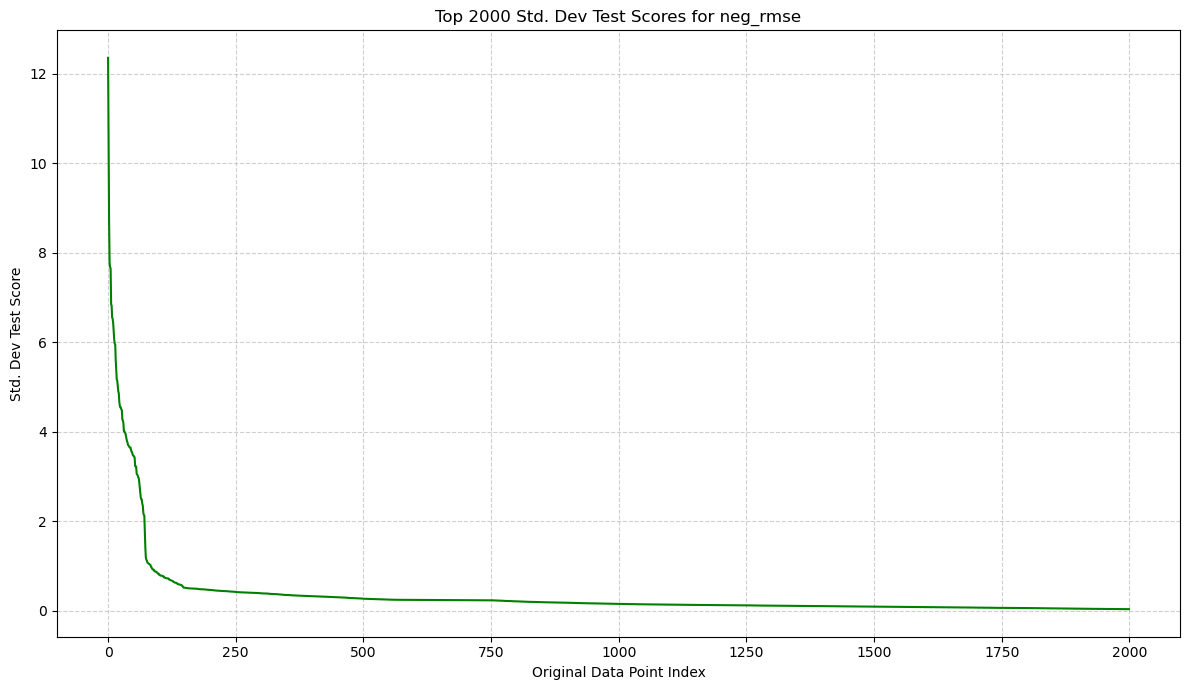

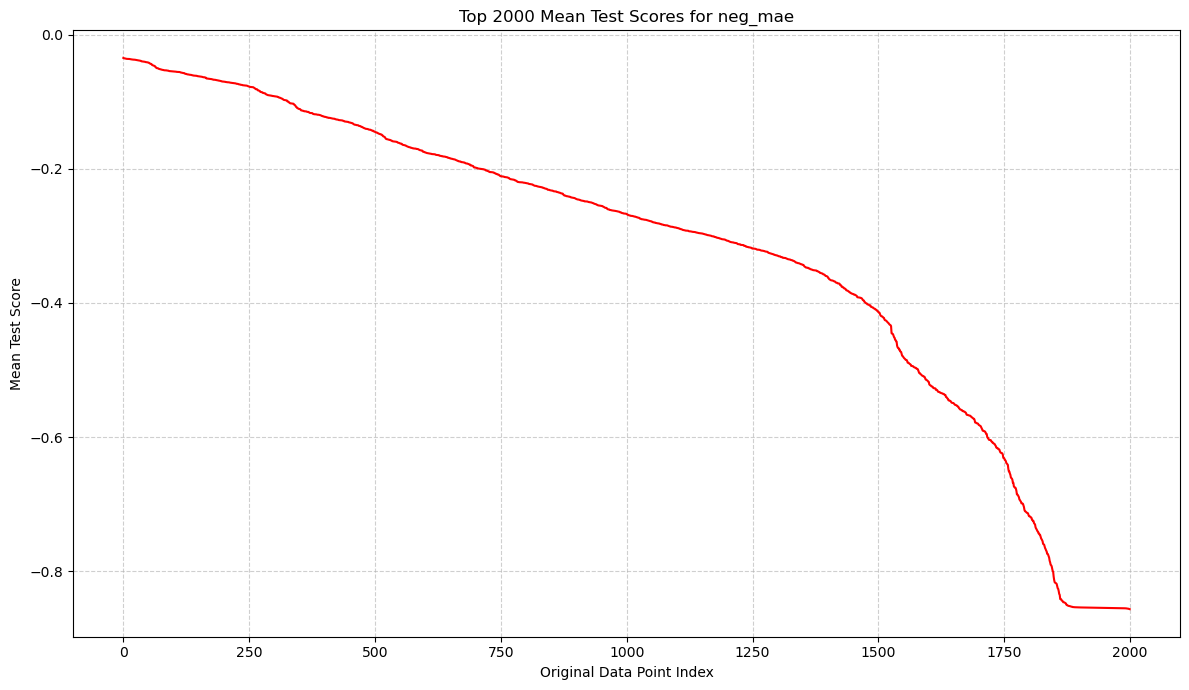

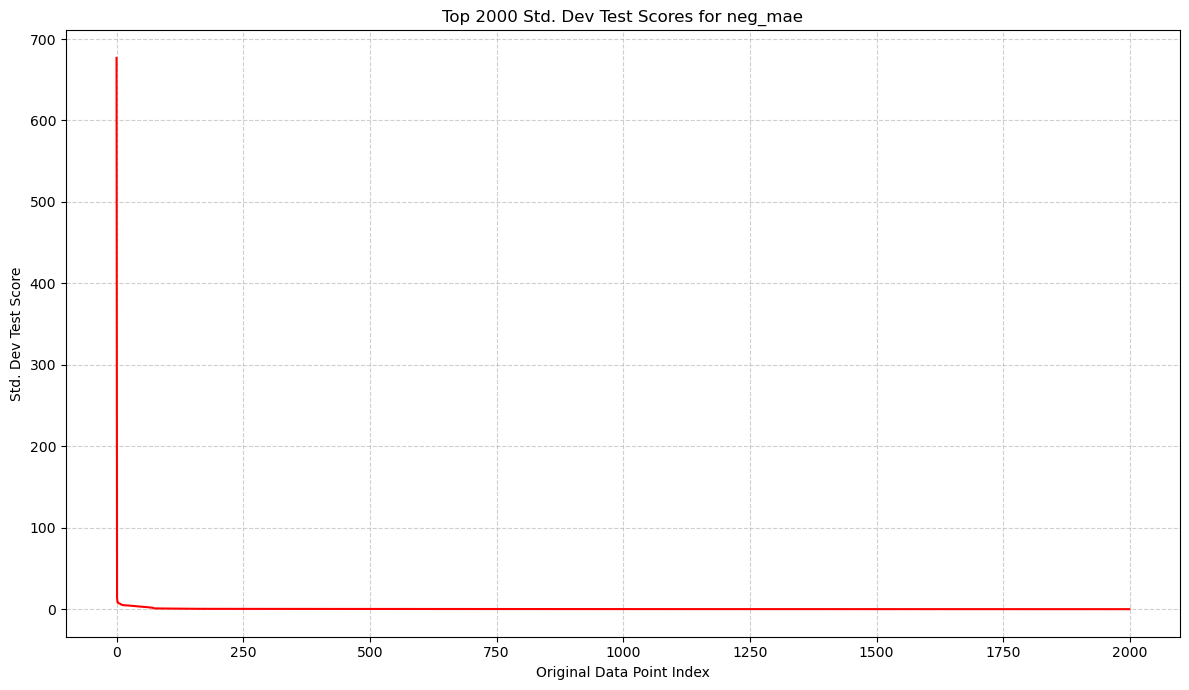

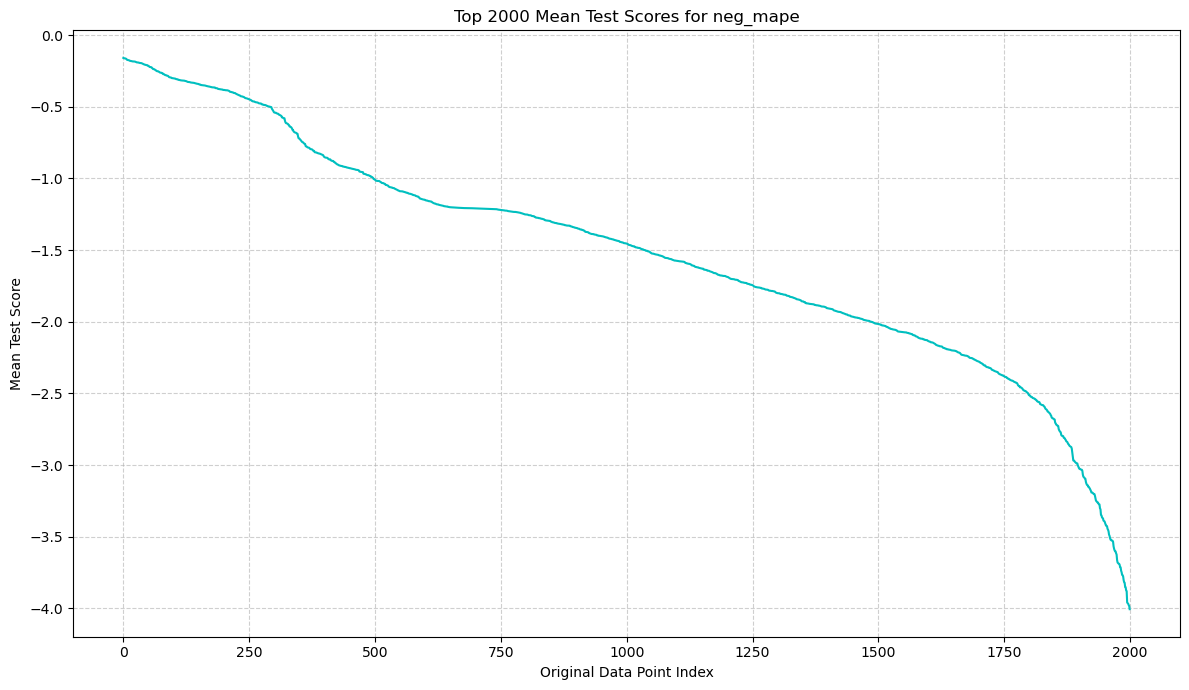

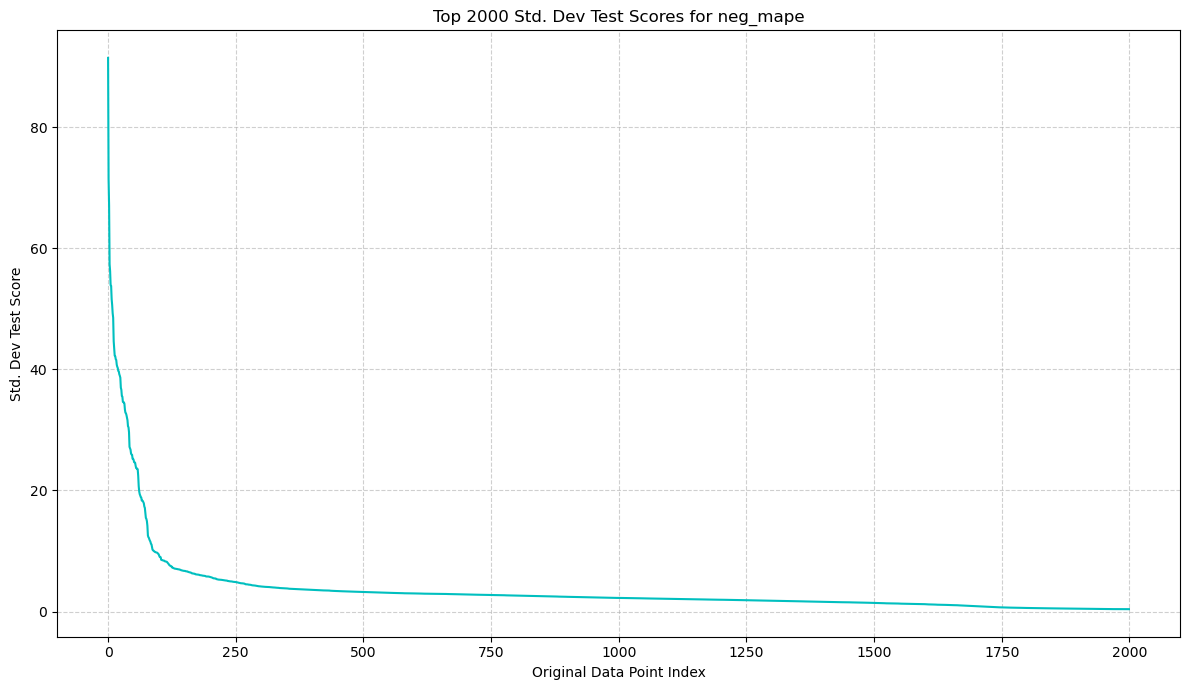

In [114]:
num_top_values = 2000
colors: list[str] = ["b", "g", "r", "c", "tab:orange", "tab:purple", "tab:brown", "lime", "gold"]

plot_names = ["Mean", "Std. Dev", "Rank"] 

# Iterate through each scoring method
for i, (scoring_name, results) in enumerate(results_mlp.items()):
	table: pd.DataFrame = results["result_table"]

	mean_test_scores: pd.Series = table["mean_test_score"]
	std_test_scores: pd.Series = table["std_test_score"]
	
	test_scores: list[pd.Series] = [mean_test_scores, std_test_scores]
	for j, test_score in enumerate(test_scores):
		# Sort the mean test scores in descending order and select the top N values
		# .sort_values(ascending=False) sorts the Series
		# .head(num_top_values) selects the top N values
		top_scores = test_score.sort_values(ascending=False).head(num_top_values)

		# Create a figure and axes for the line plot
		fig, ax = plt.subplots(figsize=(12, 7))

		# Plot the top mean scores as a line graph
		# The x-axis will be the original index of these top scores
		color = colors[i % len(colors)] # Cycle through colors for different scoring methods
		ax.plot(top_scores.values, color=color)

		# Set titles and labels
		ax.set_title(f'Top {num_top_values} {plot_names[j]} Test Scores for {scoring_name}')
		ax.set_xlabel('Original Data Point Index')
		ax.set_ylabel(f'{plot_names[j]} Test Score')

		# Add a grid for better readability
		ax.grid(True, linestyle='--', alpha=0.6)

		# Improve layout
		fig.tight_layout()

		# Display the figure
		plt.show(fig)

		fig.savefig(f"figures/SVR_top_{num_top_values}_{plot_names[j].lower()}_{scoring_name}_point.png")

		# Close the figure
		plt.close(fig)

	# Clean up variables
	del table
	del mean_test_scores
	del std_test_scores
	del top_scores
	del fig
	del ax